The group catalog contains information about subhalos, halos, and their properties, including subhalo IDs.

The snapshot file (e.g., snap_099.99.hdf5) contains particle data like positions, velocities, and masses, but it doesn't directly store subhalo IDs or the hierarchical structure of subhalos and halos. This information is stored in the group catalog files associated with the snapshot.

### List all information the Snapshot-99/snap_099.99 have including dataset shapes, data types, and attributes

In [ ]:
import h5py

# File path to the HDF5 file
snapshot_file_path = "/home/gs/Illustris_data/Snapshot-99/snap_099.99.hdf5"

# Open the HDF5 file
with h5py.File(snapshot_file_path, 'r') as hdf_file:
    
    def print_structure(name, obj):
        """Function to print the structure of the HDF5 file."""
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        if hasattr(obj, 'attrs'):
            for attr_name, attr_value in obj.attrs.items():
                print(f"  Attribute: {attr_name} = {attr_value}")

    # Recursively print the structure of the file
    hdf_file.visititems(print_structure)


### List all information from group catalog id= 099.99.hdf5

In [ ]:
import h5py

def list_hdf5_contents(file_path):
    with h5py.File(file_path, 'r') as f:
        def print_attrs(name, obj):
            print(f"{name}: {obj}")
        f.visititems(print_attrs)

# Check contents of the group catalog file
group_catalog_file = "/home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.99.hdf5"
list_hdf5_contents(group_catalog_file)


### List of Subhaloes in Snapshot 099.99.hdf5
subhalo IDs are typically found in the dataset labeled Subhalo/SubhaloIDMostbound

In [ ]:
import h5py
import pandas as pd

# Function to read and list subhaloes from the group catalog file
def list_subhaloes(group_catalog_file):
    """
    Lists all subhaloes in the given group catalog file.

    Parameters:
        group_catalog_file (str): Path to the group catalog HDF5 file.

    Returns:
        pd.DataFrame: A dataframe containing basic properties of each subhalo.
    """
    with h5py.File(group_catalog_file, 'r') as f:
        # Extract relevant properties of the subhaloes
        subhalo_ids = f['Subhalo/SubhaloIDMostbound'][:]  # IDs of the most-bound particle in each subhalo
        subhalo_positions = f['Subhalo/SubhaloPos'][:]  # Positions of all subhaloes
        subhalo_masses = f['Subhalo/SubhaloMass'][:]  # Mass of each subhalo
        subhalo_radii = f['Subhalo/SubhaloHalfmassRad'][:]  # Half-mass radius of each subhalo

    # Create a DataFrame to organize the data
    subhaloes_df = pd.DataFrame({
        'SubhaloID': subhalo_ids,
        'Position_X': subhalo_positions[:, 0],
        'Position_Y': subhalo_positions[:, 1],
        'Position_Z': subhalo_positions[:, 2],
        'Mass': subhalo_masses,
        'HalfmassRadius': subhalo_radii
    })

    return subhaloes_df

# Define the path to the group catalog file
group_catalog_file = "/home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.99.hdf5"

# List subhaloes and store them in a DataFrame
subhaloes_df = list_subhaloes(group_catalog_file)

# Display the DataFrame with basic information about each subhalo
print("List of Subhaloes in Snapshot:")
print(subhaloes_df)


### Check the overall distribution of gas particles to ensure they exist in dataset

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(gas_positions[:, 0], gas_positions[:, 1], s=0.1, alpha=0.5)
plt.title('Gas Particle Distribution')
plt.xlabel('X Position (kpc)')
plt.ylabel('Y Position (kpc)')
plt.show()


### the total mass of gas in fof_subhalo_tab_099.hdf5
SubhaloMassType array correspond to different types of mass:
Index 0: Gas
Index 1: Dark Matter
Index 2: Other (e.g., neutrinos)
Index 3: Stars
Index 4: Black Holes
Index 5: Wind (e.g., galactic winds)


In [ ]:
with h5py.File(groupcat_file_path, 'r') as f:
    subhalo_gas_mass = f['Subhalo/SubhaloMassType'][subhalo_ids, 0]  # 0 index corresponds to gas
    print(f"Subhalo Gas Mass: {subhalo_gas_mass}")


Subhalo Gas Mass: 0.3575506806373596 = 3.5755 × 10^9 solar masses of gas.

In [ ]:
with h5py.File(groupcat_file_path, 'r') as f:
    subhalo_gas_masses = f['Subhalo/SubhaloMassType'][:, 0]  # 0 index is for gas (: all subhalos)
    subhalos_with_gas = np.where(subhalo_gas_masses > 0)[0]  #subhalos that have a gas mass greater than zero
    print(f"Subhalos with gas: {subhalos_with_gas}")
   
    #np.where returns the indices of subhalos where this condition is true.


# 2D gas density map

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter #to reduce noise and detail in image

# Paths to the HDF5 files
snapshot_file_path = "/home/gs/Illustris_data/Snapshot-99/snap_099.99.hdf5"
groupcat_file_path = "/home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.99.hdf5"

# Select a subhalo with gas (e.g., Subhalo ID 0)
subhalo_id = 1319  # we can choose any subhalo ID from above list

# Function to read gas particle data
def read_gas_data(file_path):
    """Reads the positions and densities of gas particles from the HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        if 'PartType0' not in f:
            raise KeyError("No gas particle data ('PartType0') found in this file.")
        positions = f['PartType0/Coordinates'][:]  # Gas particle positions
        densities = f['PartType0/Density'][:]      # Gas particle densities
    return positions, densities

# Function to read subhalo position and half-mass radius
def read_subhalo_data(file_path, subhalo_id):
    """Reads the position and half-mass radius of a specific subhalo from the group catalog."""
    with h5py.File(file_path, 'r') as f:
        subhalo_positions = f['Subhalo/SubhaloPos'][:]
        subhalo_half_mass_radii = f['Subhalo/SubhaloHalfmassRad'][:]
        
        subhalo_position = subhalo_positions[subhalo_id]  # Position of the subhalo
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]  # Half-mass radius of the subhalo
    return subhalo_position, subhalo_radius

# Function to filter gas particles near the subhalo
def filter_gas_particles(positions, densities, subhalo_position, radius):
    """Filters gas particles within a given radius of the subhalo position."""
    distances = np.sqrt(np.sum((positions - subhalo_position)**2, axis=1)) 
    within_radius = distances < radius
    return positions[within_radius], densities[within_radius]

# Function to create and display gas density map
def create_gas_density_map(positions, densities, resolution=500, smoothing=1.0):
    """Create and display a 2D gas density map for the selected subhalo."""
    if len(positions) == 0:
        print("No gas particles found in this region.")
        return
    
    x = positions[:, 0]  # X positions
    y = positions[:, 1]  # Y positions
    density_map, xedges, yedges = np.histogram2d(x, y, bins=resolution, weights=densities)
    smoothed_density_map = gaussian_filter(density_map, sigma=smoothing)

    # Plot the density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(smoothed_density_map.T + 1e-5), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma')
    plt.colorbar(label='log(Gas Density)')
    plt.title(f'Gas Density Map for Subhalo {subhalo_id}')
    plt.xlabel('X Position (kpc)')
    plt.ylabel('Y Position (kpc)')
    plt.show()

# Main execution
gas_positions, gas_densities = read_gas_data(snapshot_file_path)
subhalo_position, subhalo_radius = read_subhalo_data(groupcat_file_path, subhalo_id)

# Check if subhalo radius and position are valid
print(f"Subhalo Position: {subhalo_position}, Subhalo Radius: {subhalo_radius}")

# Increase the radius for more particles
radius_kpc = subhalo_radius * 100  #  adjust this if necessary 
#the gas particles within 18 times the subhalo's half-mass radius

# Filter gas particles within the subhalo's expanded radius
filtered_positions, filtered_densities = filter_gas_particles(gas_positions, gas_densities, subhalo_position, radius_kpc)

# Check the number of particles found
print(f"Number of gas particles selected: {len(filtered_positions)}")

# Create and display the gas density map if particles are found
create_gas_density_map(filtered_positions, filtered_densities, resolution=500, smoothing=2.0)


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Paths to the HDF5 files
snapshot_file_path = "/home/gs/Illustris_data/Snapshot-99/snap_099.99.hdf5"
groupcat_file_path = "/home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.99.hdf5"

# Select a subhalo with gas (e.g., Subhalo ID 0)
subhalo_id = 11  # You can choose any subhalo ID from your list

# Function to read gas particle data
def read_gas_data(file_path):
    """Reads the positions and densities of gas particles from the HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        if 'PartType0' not in f:
            raise KeyError("No gas particle data ('PartType0') found in this file.")
        positions = f['PartType0/Coordinates'][:]  # Gas particle positions
        densities = f['PartType0/Density'][:]      # Gas particle densities
    return positions, densities

# Function to read subhalo position and half-mass radius
def read_subhalo_data(file_path, subhalo_id):
    """Reads the position and half-mass radius of a specific subhalo from the group catalog."""
    with h5py.File(file_path, 'r') as f:
        subhalo_positions = f['Subhalo/SubhaloPos'][:]
        subhalo_half_mass_radii = f['Subhalo/SubhaloHalfmassRad'][:]
        
        subhalo_position = subhalo_positions[subhalo_id]  # Position of the subhalo
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]  # Half-mass radius of the subhalo
    return subhalo_position, subhalo_radius

# Function to filter gas particles near the subhalo
def filter_gas_particles(positions, densities, subhalo_position, radius):
    """Filters gas particles within a given radius of the subhalo position."""
    distances = np.sqrt(np.sum((positions - subhalo_position)**2, axis=1))
    within_radius = distances < radius
    return positions[within_radius], densities[within_radius]

# Function to create and display gas density 3D map
def create_gas_density_3d_map(positions, densities, resolution=100, smoothing=1.0):
    """Create and display a 3D gas density map for the selected subhalo."""
    if len(positions) == 0:
        print("No gas particles found in this region.")
        return
    
    # Extracting X, Y, Z positions
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    
    # Create 3D density map
    hist, edges = np.histogramdd(positions, bins=resolution, weights=densities)
    smoothed_hist = gaussian_filter(hist, sigma=smoothing)
    
    # Prepare the grid for 3D plotting
    xedges, yedges, zedges = edges
    X, Y, Z = np.meshgrid((xedges[:-1] + xedges[1:]) / 2,
                          (yedges[:-1] + yedges[1:]) / 2,
                          (zedges[:-1] + zedges[1:]) / 2)
    
    # Plotting the 3D density map
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Using the smoothed density map to color the points
    ax.scatter(X.ravel(), Y.ravel(), Z.ravel(), c=np.log10(smoothed_hist.ravel() + 1e-5), cmap='plasma', marker='o')

    # Setting the labels and title
    ax.set_xlabel('X Position (kpc)')
    ax.set_ylabel('Y Position (kpc)')
    ax.set_zlabel('Z Position (kpc)')
    ax.set_title(f'3D Gas Density Map for Subhalo {subhalo_id}')

    plt.show()

# Main execution
gas_positions, gas_densities = read_gas_data(snapshot_file_path)
subhalo_position, subhalo_radius = read_subhalo_data(groupcat_file_path, subhalo_id)

# Check if subhalo radius and position are valid
print(f"Subhalo Position: {subhalo_position}, Subhalo Radius: {subhalo_radius}")

# Increase the radius for more particles
radius_kpc = subhalo_radius * 2000  # You can adjust this if necessary

# Filter gas particles within the subhalo's expanded radius
filtered_positions, filtered_densities = filter_gas_particles(gas_positions, gas_densities, subhalo_position, radius_kpc)

# Check the number of particles found
print(f"Number of gas particles selected: {len(filtered_positions)}")

# Create and display the 3D gas density map if particles are found
create_gas_density_3d_map(filtered_positions, filtered_densities, resolution=100, smoothing=2.0)


In [ ]:
subhalo_id = 1
# Function to read gas particle data
def read_gas_data(file_path):
    """Reads the positions and densities of gas particles from the HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        if 'PartType0' not in f:
            raise KeyError("No gas particle data ('PartType0') found in this file.")
        positions = f['PartType0/Coordinates'][:]  # Gas particle positions
        densities = f['PartType0/Density'][:]      # Gas particle densities
    return positions, densities

# Function to read subhalo properties
def read_subhalo_data(file_path, subhalo_id):
    """Reads the position, half-mass radius, and mass of a specific subhalo from the group catalog."""
    with h5py.File(file_path, 'r') as f:
        subhalo_positions = f['Subhalo/SubhaloPos'][:]
        subhalo_half_mass_radii = f['Subhalo/SubhaloHalfmassRad'][:]
        subhalo_masses = f['Subhalo/SubhaloMass'][:]  # Subhalo masses in 10^10 solar masses

        subhalo_position = subhalo_positions[subhalo_id]  # Position of the subhalo
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]  # Half-mass radius of the subhalo
        subhalo_mass = subhalo_masses[subhalo_id]  # Mass of the subhalo in 10^10 solar masses
    return subhalo_position, subhalo_radius, subhalo_mass

# Function to filter gas particles near the subhalo
def filter_gas_particles(positions, densities, subhalo_position, radius):
    """Filters gas particles within a given radius of the subhalo position."""
    distances = np.sqrt(np.sum((positions - subhalo_position)**2, axis=1)) 
    within_radius = distances < radius
    return positions[within_radius], densities[within_radius]

# Function to create and display gas density map
def create_gas_density_map(positions, densities, resolution=500, smoothing=1.0):
    """Create and display a 2D gas density map for the selected subhalo."""
    if len(positions) == 0:
        print("No gas particles found in this region.")
        return
    
    x = positions[:, 0]  # X positions
    y = positions[:, 1]  # Y positions
    density_map, xedges, yedges = np.histogram2d(x, y, bins=resolution, weights=densities)
    smoothed_density_map = gaussian_filter(density_map, sigma=smoothing)

    # Plot the density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(smoothed_density_map.T + 1e-1), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma')
    plt.colorbar(label='log(Gas Density)')
    plt.title(f'Gas Density Map for Subhalo {subhalo_id}')
    plt.xlabel('X Position (kpc)')
    plt.ylabel('Y Position (kpc)')
    plt.show()

# Main execution
gas_positions, gas_densities = read_gas_data(snapshot_file_path)

# Loop through subhaloes to filter based on gas content or mass
for subhalo_id in range(100): 
    subhalo_position, subhalo_radius, subhalo_mass = read_subhalo_data(groupcat_file_path, subhalo_id)

    radius_kpc = subhalo_radius * 10  # Adjust this if necessary

    # Filter gas particles within the subhalo's expanded radius
    filtered_positions, filtered_densities = filter_gas_particles(gas_positions, gas_densities, subhalo_position, radius_kpc)
#close enough to the subhalo to likely be gravitationally bound 
    # Filter condition: subhalo has gas particles OR mass > 10^10 solar masses
    if len(filtered_positions) > 0 or subhalo_mass > 1.0:  # Mass is in 10^10 solar masses
        print(f"Subhalo {subhalo_id} selected with mass {subhalo_mass * 1e10:.2e} solar masses")

        # Create and display the gas density map if particles are found
        if len(filtered_positions) > 0:
            create_gas_density_map(filtered_positions, filtered_densities, resolution=500, smoothing=2.0)



In [ ]:
gas_group_numbers = f['PartType0/GroupNr'][:]  


In [ ]:
# Function to read gas particle data
def read_gas_data(file_path):
    """Reads the positions and densities of gas particles from the HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        if 'PartType0' not in f:
            raise KeyError("No gas particle data ('PartType0') found in this file.")
        positions = f['PartType0/Coordinates'][:]  # Gas particle positions
        densities = f['PartType0/Density'][:]      # Gas particle densities
    return positions, densities

# Function to read subhalo properties
def read_subhalo_data(file_path, subhalo_id):
    """Reads the position, half-mass radius, and mass of a specific subhalo from the group catalog."""
    with h5py.File(file_path, 'r') as f:
        subhalo_positions = f['Subhalo/SubhaloPos'][:]
        subhalo_half_mass_radii = f['Subhalo/SubhaloHalfmassRad'][:]
        subhalo_masses = f['Subhalo/SubhaloMass'][:]  # Subhalo masses in 10^10 solar masses

        subhalo_position = subhalo_positions[subhalo_id]  # Position of the subhalo
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]  # Half-mass radius of the subhalo
        subhalo_mass = subhalo_masses[subhalo_id]  # Mass of the subhalo in 10^10 solar masses
    return subhalo_position, subhalo_radius, subhalo_mass

# Function to filter gas particles near the subhalo
def filter_gas_particles(positions, densities, subhalo_position, radius):
    """Filters gas particles within a given radius of the subhalo position."""
    distances = np.sqrt(np.sum((positions - subhalo_position)**2, axis=1)) 
    within_radius = distances < radius
    return positions[within_radius], densities[within_radius]

# Function to create and display gas density map
def create_gas_density_map(positions, densities, resolution=500, smoothing=1.0):
    """Create and display a 2D gas density map for the selected subhalo."""
    if len(positions) == 0:
        print("No gas particles found in this region.")
        return
    
    x = positions[:, 0]  # X positions
    y = positions[:, 1]  # Y positions
    density_map, xedges, yedges = np.histogram2d(x, y, bins=resolution, weights=densities)
    smoothed_density_map = gaussian_filter(density_map, sigma=smoothing)

    # Plot the density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(smoothed_density_map.T + 1e-5), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma')
    plt.colorbar(label='log(Gas Density)')
    plt.title(f'Gas Density Map for Subhalo {subhalo_id}')
    plt.xlabel('X Position (kpc)')
    plt.ylabel('Y Position (kpc)')
    plt.show()

# Main execution
gas_positions, gas_densities = read_gas_data(snapshot_file_path)

# Loop through subhaloes to filter based on gas content or mass
for subhalo_id in range(100): 
    subhalo_position, subhalo_radius, subhalo_mass = read_subhalo_data(groupcat_file_path, subhalo_id)

    radius_kpc = subhalo_radius * 20  # Adjust this if necessary

    # Filter gas particles within the subhalo's expanded radius
    filtered_positions, filtered_densities = filter_gas_particles(gas_positions, gas_densities, subhalo_position, radius_kpc)
#close enough to the subhalo to likely be gravitationally bound 
    # Filter condition: subhalo has gas particles OR mass > 10^10 solar masses
    if len(filtered_positions) > 0 or subhalo_mass > 1.0:  # Mass is in 10^10 solar masses
        print(f"Subhalo {subhalo_id} selected with mass {subhalo_mass * 1e10:.2e} solar masses")

Subhalo Position: [23524.031 65438.906 23212.912]
Subhalo Radius: 7.703452110290527
Subhalo Mass: 4.0210676193237305
Number of gas particles selected: 255302


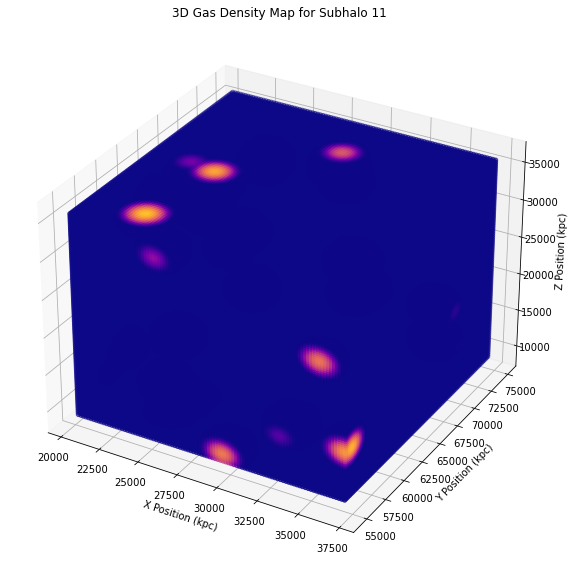

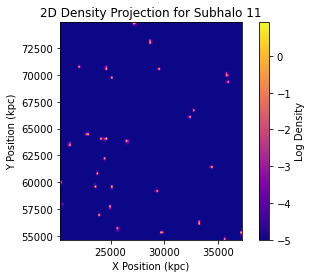

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Paths to the HDF5 files
snapshot_file_path = "/home/gs/Illustris_data/Snapshot-99/snap_099.99.hdf5"
groupcat_file_path = "/home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.99.hdf5"

# Choose a subhalo ID to analyze
subhalo_id = 11  # Adjust based on your target subhalo

# Function to read gas particle data
def read_gas_data(file_path):
    """Reads the positions and densities of gas particles from the HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        if 'PartType0' not in f:
            raise KeyError("No gas particle data ('PartType0') found in this file.")
        positions = f['PartType0/Coordinates'][:]  # Gas particle positions
        densities = f['PartType0/Density'][:]      # Gas particle densities
    return positions, densities

# Function to read subhalo position, radius, and other properties
def read_subhalo_data(file_path, subhalo_id):
    """Reads the position, half-mass radius, and other properties of a specific subhalo."""
    with h5py.File(file_path, 'r') as f:
        subhalo_positions = f['Subhalo/SubhaloPos'][:]
        subhalo_half_mass_radii = f['Subhalo/SubhaloHalfmassRad'][:]
        subhalo_masses = f['Subhalo/SubhaloMass'][:]
        
        subhalo_position = subhalo_positions[subhalo_id]
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]
        subhalo_mass = subhalo_masses[subhalo_id]
    return subhalo_position, subhalo_radius, subhalo_mass

# Function to filter gas particles near the subhalo
def filter_gas_particles(positions, densities, subhalo_position, radius):
    """Filters gas particles within a given radius of the subhalo position."""
    distances = np.sqrt(np.sum((positions - subhalo_position)**2, axis=1))
    within_radius = distances < radius
    return positions[within_radius], densities[within_radius]

# Function to create and display a 3D gas density map
def create_gas_density_3d_map(positions, densities, resolution=100, smoothing=1.0):
    """Create and display a 3D gas density map for the selected subhalo."""
    if len(positions) == 0:
        print("No gas particles found in this region.")
        return
    
    hist, edges = np.histogramdd(positions, bins=resolution, weights=densities)
    smoothed_hist = gaussian_filter(hist, sigma=smoothing)
    
    xedges, yedges, zedges = edges
    X, Y, Z = np.meshgrid((xedges[:-1] + xedges[1:]) / 2,
                          (yedges[:-1] + yedges[1:]) / 2,
                          (zedges[:-1] + zedges[1:]) / 2)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X.ravel(), Y.ravel(), Z.ravel(), c=np.log10(smoothed_hist.ravel() + 1e-5), cmap='plasma', marker='o')

    ax.set_xlabel('X Position (kpc)')
    ax.set_ylabel('Y Position (kpc)')
    ax.set_zlabel('Z Position (kpc)')
    ax.set_title(f'3D Gas Density Map for Subhalo {subhalo_id}')
    plt.show()

# Function to create a 2D density projection of gas particles
def create_density_projection(positions, densities, resolution=100):
    """Create and display a 2D density projection along the z-axis."""
    proj, xedges, yedges = np.histogram2d(positions[:, 0], positions[:, 1], bins=resolution, weights=densities)
    
    plt.imshow(np.log10(proj + 1e-5), cmap='plasma', origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar(label='Log Density')
    plt.xlabel('X Position (kpc)')
    plt.ylabel('Y Position (kpc)')
    plt.title(f'2D Density Projection for Subhalo {subhalo_id}')
    plt.show()

# Main execution
gas_positions, gas_densities = read_gas_data(snapshot_file_path)
subhalo_position, subhalo_radius, subhalo_mass = read_subhalo_data(groupcat_file_path, subhalo_id)

# Display basic subhalo info
print(f"Subhalo Position: {subhalo_position}")
print(f"Subhalo Radius: {subhalo_radius}")
print(f"Subhalo Mass: {subhalo_mass}")

# Choose a smaller radius for focusing on a single galaxy (subhalo) in a smaller box
small_radius_kpc = subhalo_radius * 2000 #the multiplier as needed

# Filter gas particles within the subhalo's smaller radius
filtered_positions, filtered_densities = filter_gas_particles(gas_positions, gas_densities, subhalo_position, small_radius_kpc)
print(f"Number of gas particles selected: {len(filtered_positions)}")

# Create a 3D gas density map
create_gas_density_3d_map(filtered_positions, filtered_densities, resolution=100, smoothing=2.0)

# Create a 2D density projection of the gas particles
create_density_projection(filtered_positions, filtered_densities, resolution=100)


In [8]:
pip install h5py numpy matplotlib astropy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Found 448 group catalog files.


Reading subhalo data:   0%|          | 1/448 [00:00<00:52,  8.56it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.0.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'S

Reading subhalo data:   1%|          | 3/448 [00:00<00:33, 13.20it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.10.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.10.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.100.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', '

Reading subhalo data:   1%|          | 5/448 [00:00<00:46,  9.47it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.101.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:   2%|▏         | 7/448 [00:00<00:49,  8.88it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.103.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:   2%|▏         | 10/448 [00:01<00:47,  9.31it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:   3%|▎         | 15/448 [00:01<00:43,  9.95it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.107.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:   4%|▍         | 18/448 [00:01<00:32, 13.13it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:   5%|▌         | 23/448 [00:01<00:26, 15.80it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:   7%|▋         | 31/448 [00:02<00:16, 24.58it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:   8%|▊         | 37/448 [00:02<00:17, 23.76it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.127.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:   9%|▉         | 41/448 [00:02<00:17, 23.89it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  10%|▉         | 44/448 [00:02<00:16, 24.16it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.137.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  11%|█▏        | 51/448 [00:03<00:23, 17.24it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.14.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.14.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.140.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', '

Reading subhalo data:  12%|█▏        | 55/448 [00:03<00:19, 20.11it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  14%|█▍        | 62/448 [00:03<00:17, 22.13it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.15.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.150.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType',

Reading subhalo data:  15%|█▌        | 68/448 [00:04<00:16, 22.44it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.155.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  16%|█▌        | 72/448 [00:04<00:15, 24.07it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.160.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  18%|█▊        | 79/448 [00:04<00:14, 25.15it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.166.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  19%|█▉        | 85/448 [00:04<00:14, 24.37it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.171.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  20%|█▉        | 88/448 [00:04<00:18, 19.60it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  20%|██        | 91/448 [00:05<00:22, 15.70it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  21%|██        | 93/448 [00:05<00:26, 13.59it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  21%|██        | 95/448 [00:05<00:32, 10.82it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  22%|██▏       | 97/448 [00:05<00:35,  9.99it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.185.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  22%|██▏       | 99/448 [00:06<00:37,  9.21it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  23%|██▎       | 101/448 [00:06<00:44,  7.76it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  23%|██▎       | 103/448 [00:06<00:41,  8.35it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  24%|██▎       | 106/448 [00:07<00:43,  7.84it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  25%|██▍       | 110/448 [00:07<00:40,  8.45it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.196.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  25%|██▌       | 112/448 [00:08<00:45,  7.46it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  26%|██▌       | 115/448 [00:08<00:35,  9.47it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.200.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  26%|██▌       | 117/448 [00:08<00:35,  9.42it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  27%|██▋       | 119/448 [00:08<00:34,  9.48it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  27%|██▋       | 122/448 [00:09<00:39,  8.34it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.206.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  28%|██▊       | 124/448 [00:09<00:41,  7.88it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  29%|██▊       | 128/448 [00:09<00:30, 10.53it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  29%|██▉       | 130/448 [00:09<00:34,  9.35it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  29%|██▉       | 132/448 [00:10<00:32,  9.68it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  30%|██▉       | 134/448 [00:10<00:33,  9.25it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.218.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  31%|███       | 137/448 [00:10<00:34,  9.07it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  31%|███       | 139/448 [00:10<00:33,  9.30it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  31%|███▏      | 140/448 [00:11<00:35,  8.57it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  32%|███▏      | 142/448 [00:11<00:39,  7.73it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.225.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  33%|███▎      | 146/448 [00:11<00:34,  8.82it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  33%|███▎      | 148/448 [00:12<00:32,  9.12it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.23.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.230.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType',

Reading subhalo data:  33%|███▎      | 149/448 [00:12<00:33,  9.03it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  34%|███▎      | 151/448 [00:12<00:38,  7.74it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  34%|███▍      | 153/448 [00:12<00:41,  7.15it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  35%|███▍      | 155/448 [00:13<00:38,  7.55it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  35%|███▌      | 157/448 [00:13<00:34,  8.49it/s]

 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad',

Reading subhalo data:  36%|███▌      | 160/448 [00:13<00:31,  9.11it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.240.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  36%|███▋      | 163/448 [00:13<00:36,  7.71it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  37%|███▋      | 166/448 [00:14<00:31,  9.05it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  37%|███▋      | 167/448 [00:14<01:05,  4.31it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  38%|███▊      | 171/448 [00:15<00:37,  7.47it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.25.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.25.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.250.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', '

Reading subhalo data:  39%|███▊      | 173/448 [00:15<00:35,  7.75it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  39%|███▉      | 175/448 [00:15<00:31,  8.73it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  40%|███▉      | 177/448 [00:15<00:32,  8.28it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  40%|███▉      | 179/448 [00:16<00:31,  8.56it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  41%|████      | 183/448 [00:16<00:27,  9.74it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  41%|████▏     | 185/448 [00:16<00:29,  8.97it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  42%|████▏     | 188/448 [00:17<00:26,  9.74it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  42%|████▏     | 190/448 [00:17<00:40,  6.32it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  43%|████▎     | 193/448 [00:17<00:37,  6.86it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  44%|████▎     | 195/448 [00:18<00:34,  7.31it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  44%|████▍     | 197/448 [00:18<00:30,  8.23it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.275.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  45%|████▍     | 200/448 [00:18<00:26,  9.41it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  45%|████▌     | 203/448 [00:18<00:22, 10.71it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  46%|████▌     | 205/448 [00:19<00:22, 10.93it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  46%|████▌     | 207/448 [00:19<00:24,  9.96it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.284.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  47%|████▋     | 209/448 [00:19<00:23, 10.31it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.286.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  47%|████▋     | 212/448 [00:19<00:24,  9.49it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  48%|████▊     | 215/448 [00:20<00:21, 10.92it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.290.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  48%|████▊     | 217/448 [00:20<00:20, 11.14it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  49%|████▉     | 220/448 [00:21<00:38,  5.99it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.295.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  49%|████▉     | 221/448 [00:21<00:35,  6.43it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  50%|████▉     | 223/448 [00:21<00:31,  7.25it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  51%|█████     | 229/448 [00:21<00:20, 10.72it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  52%|█████▏    | 231/448 [00:22<00:21,  9.92it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  52%|█████▏    | 233/448 [00:22<00:20, 10.28it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.307.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  53%|█████▎    | 238/448 [00:23<00:29,  7.15it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  54%|█████▎    | 240/448 [00:23<00:27,  7.60it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.312.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  54%|█████▍    | 242/448 [00:23<00:24,  8.45it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  54%|█████▍    | 244/448 [00:23<00:24,  8.44it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.317.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  55%|█████▌    | 248/448 [00:24<00:20,  9.68it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  56%|█████▌    | 250/448 [00:24<00:19, 10.18it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  57%|█████▋    | 254/448 [00:25<00:24,  8.01it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.325.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  57%|█████▋    | 256/448 [00:25<00:22,  8.60it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  58%|█████▊    | 258/448 [00:25<00:23,  8.19it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.33.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.33.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.330.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', '

Reading subhalo data:  58%|█████▊    | 261/448 [00:26<00:26,  7.12it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  59%|█████▉    | 264/448 [00:26<00:24,  7.48it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  59%|█████▉    | 266/448 [00:26<00:22,  8.20it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  60%|█████▉    | 268/448 [00:26<00:21,  8.43it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.339.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  61%|██████    | 272/448 [00:27<00:18,  9.56it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  61%|██████    | 274/448 [00:27<00:16, 10.25it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  62%|██████▏   | 276/448 [00:27<00:17,  9.77it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  63%|██████▎   | 281/448 [00:28<00:15, 10.62it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.349.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  63%|██████▎   | 283/448 [00:28<00:16, 10.11it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.352.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  64%|██████▎   | 285/448 [00:28<00:15, 10.26it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.354.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  65%|██████▍   | 289/448 [00:29<00:18,  8.74it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  65%|██████▍   | 291/448 [00:29<00:16,  9.29it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  65%|██████▌   | 293/448 [00:29<00:17,  8.95it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  66%|██████▌   | 295/448 [00:29<00:15,  9.62it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  66%|██████▋   | 297/448 [00:30<00:17,  8.84it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  67%|██████▋   | 300/448 [00:30<00:16,  9.00it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  68%|██████▊   | 304/448 [00:30<00:12, 11.52it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  68%|██████▊   | 306/448 [00:30<00:13, 10.86it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  69%|██████▉   | 308/448 [00:31<00:14,  9.48it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  69%|██████▉   | 310/448 [00:31<00:16,  8.62it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  70%|██████▉   | 312/448 [00:31<00:15,  8.63it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  70%|███████   | 315/448 [00:31<00:11, 12.06it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  71%|███████   | 317/448 [00:32<00:15,  8.69it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  71%|███████   | 319/448 [00:32<00:13,  9.34it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  72%|███████▏  | 321/448 [00:32<00:16,  7.83it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  72%|███████▏  | 323/448 [00:32<00:14,  8.62it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.39.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', '

Reading subhalo data:  73%|███████▎  | 325/448 [00:33<00:19,  6.44it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  73%|███████▎  | 328/448 [00:33<00:16,  7.32it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  74%|███████▎  | 330/448 [00:33<00:15,  7.53it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  75%|███████▍  | 334/448 [00:34<00:10, 10.48it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  75%|███████▌  | 338/448 [00:34<00:07, 13.93it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  76%|███████▋  | 342/448 [00:34<00:09, 11.70it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.404.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  77%|███████▋  | 344/448 [00:35<00:12,  8.12it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  77%|███████▋  | 346/448 [00:35<00:11,  8.66it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.409.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  78%|███████▊  | 348/448 [00:35<00:11,  9.06it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  78%|███████▊  | 350/448 [00:35<00:10,  9.12it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.412.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  79%|███████▉  | 354/448 [00:36<00:10,  8.97it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  79%|███████▉  | 356/448 [00:36<00:09,  9.71it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  80%|████████  | 360/448 [00:36<00:08, 10.40it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.42.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', '

Reading subhalo data:  81%|████████  | 362/448 [00:37<00:09,  9.54it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  81%|████████▏ | 364/448 [00:37<00:08,  9.96it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  82%|████████▏ | 366/448 [00:37<00:08,  9.24it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  82%|████████▏ | 368/448 [00:37<00:08,  9.64it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.43.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.43.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.430.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', '

Reading subhalo data:  83%|████████▎ | 372/448 [00:38<00:07, 10.15it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.431.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  84%|████████▍ | 376/448 [00:38<00:06, 10.50it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.434.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  84%|████████▍ | 378/448 [00:38<00:07,  9.14it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.437.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  85%|████████▌ | 381/448 [00:38<00:05, 11.43it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  85%|████████▌ | 383/448 [00:39<00:05, 10.90it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.442.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 

Reading subhalo data:  86%|████████▌ | 385/448 [00:39<00:06, 10.22it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  86%|████████▋ | 387/448 [00:39<00:06,  9.16it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  87%|████████▋ | 391/448 [00:39<00:04, 13.33it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  89%|████████▉ | 399/448 [00:40<00:02, 19.20it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.51.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.51.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.52.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'S

Reading subhalo data:  91%|█████████ | 408/448 [00:40<00:01, 26.59it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  92%|█████████▏| 413/448 [00:40<00:01, 30.08it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.64.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: []
'SubhaloPos' not found in /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.64.hdf5
Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.65.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'S

Reading subhalo data:  94%|█████████▍| 421/448 [00:40<00:00, 28.23it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  95%|█████████▍| 424/448 [00:40<00:00, 27.62it/s]

Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFrac

Reading subhalo data:  97%|█████████▋| 434/448 [00:41<00:00, 35.49it/s]

Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'Sub

Reading subhalo data:  99%|█████████▉| 443/448 [00:41<00:00, 32.36it/s]

Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.90.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', '

Reading subhalo data: 100%|██████████| 448/448 [00:41<00:00, 10.77it/s]


Inspecting file: /home/gs/Illustris_data/Group_catalog/fof_subhalo_tab_099.98.hdf5
Available groups: ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']
Datasets in 'Subhalo' group: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', '

Filtering gas particles:   0%|          | 1/448 [00:02<19:22,  2.60s/it]

Filtered 7383 gas particles from snap_099.0.hdf5


Filtering gas particles:   0%|          | 2/448 [00:04<18:05,  2.43s/it]

Filtered 0 gas particles from snap_099.1.hdf5


Filtering gas particles:   1%|          | 3/448 [00:07<18:24,  2.48s/it]

Filtered 0 gas particles from snap_099.10.hdf5


Filtering gas particles:   1%|          | 4/448 [00:09<17:57,  2.43s/it]

Filtered 0 gas particles from snap_099.100.hdf5


Filtering gas particles:   1%|          | 5/448 [00:12<18:12,  2.47s/it]

Filtered 0 gas particles from snap_099.101.hdf5


Filtering gas particles:   1%|▏         | 6/448 [00:14<17:59,  2.44s/it]

Filtered 0 gas particles from snap_099.102.hdf5


Filtering gas particles:   2%|▏         | 7/448 [00:17<18:59,  2.58s/it]

Filtered 0 gas particles from snap_099.103.hdf5


Filtering gas particles:   2%|▏         | 8/448 [00:20<18:33,  2.53s/it]

Filtered 0 gas particles from snap_099.104.hdf5


Filtering gas particles:   2%|▏         | 9/448 [00:22<18:13,  2.49s/it]

Filtered 0 gas particles from snap_099.105.hdf5


Filtering gas particles:   2%|▏         | 10/448 [00:25<18:33,  2.54s/it]

Filtered 0 gas particles from snap_099.106.hdf5


Filtering gas particles:   2%|▏         | 11/448 [00:27<18:08,  2.49s/it]

Filtered 0 gas particles from snap_099.107.hdf5


Filtering gas particles:   3%|▎         | 12/448 [00:30<18:32,  2.55s/it]

Filtered 0 gas particles from snap_099.108.hdf5


Filtering gas particles:   3%|▎         | 13/448 [00:32<18:08,  2.50s/it]

Filtered 0 gas particles from snap_099.109.hdf5


Filtering gas particles:   3%|▎         | 14/448 [00:34<17:48,  2.46s/it]

Filtered 0 gas particles from snap_099.11.hdf5


Filtering gas particles:   3%|▎         | 15/448 [00:37<17:54,  2.48s/it]

Filtered 0 gas particles from snap_099.110.hdf5


Filtering gas particles:   4%|▎         | 16/448 [00:39<18:01,  2.50s/it]

Filtered 0 gas particles from snap_099.111.hdf5


Filtering gas particles:   4%|▍         | 17/448 [00:42<18:00,  2.51s/it]

Filtered 0 gas particles from snap_099.112.hdf5


Filtering gas particles:   4%|▍         | 18/448 [00:44<17:56,  2.50s/it]

Filtered 0 gas particles from snap_099.113.hdf5


Filtering gas particles:   4%|▍         | 19/448 [00:47<18:45,  2.62s/it]

Filtered 0 gas particles from snap_099.114.hdf5


Filtering gas particles:   4%|▍         | 20/448 [00:50<18:08,  2.54s/it]

Filtered 0 gas particles from snap_099.115.hdf5


Filtering gas particles:   5%|▍         | 21/448 [00:52<17:49,  2.50s/it]

Filtered 0 gas particles from snap_099.116.hdf5


Filtering gas particles:   5%|▍         | 22/448 [00:55<17:56,  2.53s/it]

Filtered 0 gas particles from snap_099.117.hdf5


Filtering gas particles:   5%|▌         | 23/448 [00:57<17:40,  2.49s/it]

Filtered 0 gas particles from snap_099.118.hdf5


Filtering gas particles:   5%|▌         | 24/448 [01:00<17:30,  2.48s/it]

Filtered 0 gas particles from snap_099.119.hdf5


Filtering gas particles:   6%|▌         | 25/448 [01:02<17:16,  2.45s/it]

Filtered 0 gas particles from snap_099.12.hdf5


Filtering gas particles:   6%|▌         | 26/448 [01:05<17:26,  2.48s/it]

Filtered 0 gas particles from snap_099.120.hdf5


Filtering gas particles:   6%|▌         | 27/448 [01:07<17:13,  2.45s/it]

Filtered 0 gas particles from snap_099.121.hdf5


Filtering gas particles:   6%|▋         | 28/448 [01:09<17:01,  2.43s/it]

Filtered 0 gas particles from snap_099.122.hdf5


Filtering gas particles:   6%|▋         | 29/448 [01:12<17:00,  2.43s/it]

Filtered 0 gas particles from snap_099.123.hdf5


Filtering gas particles:   7%|▋         | 30/448 [01:14<16:55,  2.43s/it]

Filtered 0 gas particles from snap_099.124.hdf5


Filtering gas particles:   7%|▋         | 31/448 [01:17<16:48,  2.42s/it]

Filtered 0 gas particles from snap_099.125.hdf5


Filtering gas particles:   7%|▋         | 32/448 [01:19<16:48,  2.42s/it]

Filtered 0 gas particles from snap_099.126.hdf5


Filtering gas particles:   7%|▋         | 33/448 [01:22<17:05,  2.47s/it]

Filtered 0 gas particles from snap_099.127.hdf5


Filtering gas particles:   8%|▊         | 34/448 [01:24<17:29,  2.53s/it]

Filtered 0 gas particles from snap_099.128.hdf5


Filtering gas particles:   8%|▊         | 35/448 [01:27<17:43,  2.58s/it]

Filtered 0 gas particles from snap_099.129.hdf5


Filtering gas particles:   8%|▊         | 36/448 [01:29<17:31,  2.55s/it]

Filtered 0 gas particles from snap_099.13.hdf5


Filtering gas particles:   8%|▊         | 37/448 [01:32<17:04,  2.49s/it]

Filtered 0 gas particles from snap_099.130.hdf5


Filtering gas particles:   8%|▊         | 38/448 [01:35<17:54,  2.62s/it]

Filtered 0 gas particles from snap_099.131.hdf5


Filtering gas particles:   9%|▊         | 39/448 [01:37<17:26,  2.56s/it]

Filtered 0 gas particles from snap_099.132.hdf5


Filtering gas particles:   9%|▉         | 40/448 [01:39<16:58,  2.50s/it]

Filtered 0 gas particles from snap_099.133.hdf5


Filtering gas particles:   9%|▉         | 41/448 [01:42<16:59,  2.50s/it]

Filtered 0 gas particles from snap_099.134.hdf5


Filtering gas particles:   9%|▉         | 42/448 [01:45<17:21,  2.57s/it]

Filtered 0 gas particles from snap_099.135.hdf5


Filtering gas particles:  10%|▉         | 43/448 [01:47<17:04,  2.53s/it]

Filtered 0 gas particles from snap_099.136.hdf5


Filtering gas particles:  10%|▉         | 44/448 [01:50<17:07,  2.54s/it]

Filtered 0 gas particles from snap_099.137.hdf5


Filtering gas particles:  10%|█         | 45/448 [01:53<17:46,  2.65s/it]

Filtered 0 gas particles from snap_099.138.hdf5


Filtering gas particles:  10%|█         | 46/448 [01:55<17:21,  2.59s/it]

Filtered 0 gas particles from snap_099.139.hdf5


Filtering gas particles:  10%|█         | 47/448 [01:57<16:46,  2.51s/it]

Filtered 0 gas particles from snap_099.14.hdf5


Filtering gas particles:  11%|█         | 48/448 [02:00<16:29,  2.47s/it]

Filtered 0 gas particles from snap_099.140.hdf5


Filtering gas particles:  11%|█         | 49/448 [02:02<16:26,  2.47s/it]

Filtered 0 gas particles from snap_099.141.hdf5


Filtering gas particles:  11%|█         | 50/448 [02:05<16:16,  2.45s/it]

Filtered 0 gas particles from snap_099.142.hdf5


Filtering gas particles:  11%|█▏        | 51/448 [02:07<16:00,  2.42s/it]

Filtered 0 gas particles from snap_099.143.hdf5


Filtering gas particles:  12%|█▏        | 52/448 [02:10<16:09,  2.45s/it]

Filtered 0 gas particles from snap_099.144.hdf5


Filtering gas particles:  12%|█▏        | 53/448 [02:12<16:16,  2.47s/it]

Filtered 0 gas particles from snap_099.145.hdf5


Filtering gas particles:  12%|█▏        | 54/448 [02:14<16:05,  2.45s/it]

Filtered 0 gas particles from snap_099.146.hdf5


Filtering gas particles:  12%|█▏        | 55/448 [02:17<15:55,  2.43s/it]

Filtered 0 gas particles from snap_099.147.hdf5


Filtering gas particles:  12%|█▎        | 56/448 [02:19<15:57,  2.44s/it]

Filtered 0 gas particles from snap_099.148.hdf5


Filtering gas particles:  13%|█▎        | 57/448 [02:22<15:46,  2.42s/it]

Filtered 0 gas particles from snap_099.149.hdf5


Filtering gas particles:  13%|█▎        | 58/448 [02:24<16:07,  2.48s/it]

Filtered 0 gas particles from snap_099.15.hdf5


Filtering gas particles:  13%|█▎        | 59/448 [02:27<16:27,  2.54s/it]

Filtered 0 gas particles from snap_099.150.hdf5


Filtering gas particles:  13%|█▎        | 60/448 [02:30<17:25,  2.69s/it]

Filtered 0 gas particles from snap_099.151.hdf5


Filtering gas particles:  14%|█▎        | 61/448 [02:33<17:09,  2.66s/it]

Filtered 0 gas particles from snap_099.152.hdf5


Filtering gas particles:  14%|█▍        | 62/448 [02:35<16:34,  2.58s/it]

Filtered 0 gas particles from snap_099.153.hdf5


Filtering gas particles:  14%|█▍        | 63/448 [02:37<16:08,  2.52s/it]

Filtered 0 gas particles from snap_099.154.hdf5


Filtering gas particles:  14%|█▍        | 64/448 [02:40<16:20,  2.55s/it]

Filtered 0 gas particles from snap_099.155.hdf5


Filtering gas particles:  15%|█▍        | 65/448 [02:42<16:05,  2.52s/it]

Filtered 0 gas particles from snap_099.156.hdf5


Filtering gas particles:  15%|█▍        | 66/448 [02:45<15:50,  2.49s/it]

Filtered 0 gas particles from snap_099.157.hdf5


Filtering gas particles:  15%|█▍        | 67/448 [02:47<15:50,  2.49s/it]

Filtered 0 gas particles from snap_099.158.hdf5


Filtering gas particles:  15%|█▌        | 68/448 [02:50<16:06,  2.54s/it]

Filtered 0 gas particles from snap_099.159.hdf5


Filtering gas particles:  15%|█▌        | 69/448 [02:53<16:19,  2.58s/it]

Filtered 0 gas particles from snap_099.16.hdf5


Filtering gas particles:  16%|█▌        | 70/448 [02:55<16:09,  2.57s/it]

Filtered 0 gas particles from snap_099.160.hdf5


Filtering gas particles:  16%|█▌        | 71/448 [02:58<16:02,  2.55s/it]

Filtered 0 gas particles from snap_099.161.hdf5


Filtering gas particles:  16%|█▌        | 72/448 [03:00<15:53,  2.54s/it]

Filtered 0 gas particles from snap_099.162.hdf5


Filtering gas particles:  16%|█▋        | 73/448 [03:03<15:56,  2.55s/it]

Filtered 0 gas particles from snap_099.163.hdf5


Filtering gas particles:  17%|█▋        | 74/448 [03:05<15:41,  2.52s/it]

Filtered 0 gas particles from snap_099.164.hdf5


Filtering gas particles:  17%|█▋        | 75/448 [03:08<15:36,  2.51s/it]

Filtered 0 gas particles from snap_099.165.hdf5


Filtering gas particles:  17%|█▋        | 76/448 [03:11<16:17,  2.63s/it]

Filtered 0 gas particles from snap_099.166.hdf5


Filtering gas particles:  17%|█▋        | 77/448 [03:13<15:52,  2.57s/it]

Filtered 0 gas particles from snap_099.167.hdf5


Filtering gas particles:  17%|█▋        | 78/448 [03:16<15:51,  2.57s/it]

Filtered 0 gas particles from snap_099.168.hdf5


Filtering gas particles:  18%|█▊        | 79/448 [03:18<15:29,  2.52s/it]

Filtered 0 gas particles from snap_099.169.hdf5


Filtering gas particles:  18%|█▊        | 80/448 [03:20<15:02,  2.45s/it]

Filtered 0 gas particles from snap_099.17.hdf5


Filtering gas particles:  18%|█▊        | 81/448 [03:23<15:13,  2.49s/it]

Filtered 0 gas particles from snap_099.170.hdf5


Filtering gas particles:  18%|█▊        | 82/448 [03:25<15:10,  2.49s/it]

Filtered 0 gas particles from snap_099.171.hdf5


Filtering gas particles:  19%|█▊        | 83/448 [03:28<15:22,  2.53s/it]

Filtered 0 gas particles from snap_099.172.hdf5


Filtering gas particles:  19%|█▉        | 84/448 [03:31<15:19,  2.53s/it]

Filtered 0 gas particles from snap_099.173.hdf5


Filtering gas particles:  19%|█▉        | 85/448 [03:33<15:22,  2.54s/it]

Filtered 0 gas particles from snap_099.174.hdf5


Filtering gas particles:  19%|█▉        | 86/448 [03:36<15:25,  2.56s/it]

Filtered 0 gas particles from snap_099.175.hdf5


Filtering gas particles:  19%|█▉        | 87/448 [03:38<15:22,  2.56s/it]

Filtered 0 gas particles from snap_099.176.hdf5


Filtering gas particles:  20%|█▉        | 88/448 [03:41<15:31,  2.59s/it]

Filtered 0 gas particles from snap_099.177.hdf5


Filtering gas particles:  20%|█▉        | 89/448 [03:44<15:25,  2.58s/it]

Filtered 0 gas particles from snap_099.178.hdf5


Filtering gas particles:  20%|██        | 90/448 [03:46<15:17,  2.56s/it]

Filtered 0 gas particles from snap_099.179.hdf5


Filtering gas particles:  20%|██        | 91/448 [03:49<15:05,  2.54s/it]

Filtered 0 gas particles from snap_099.18.hdf5


Filtering gas particles:  21%|██        | 92/448 [03:51<15:01,  2.53s/it]

Filtered 0 gas particles from snap_099.180.hdf5


Filtering gas particles:  21%|██        | 93/448 [03:54<14:57,  2.53s/it]

Filtered 0 gas particles from snap_099.181.hdf5


Filtering gas particles:  21%|██        | 94/448 [03:56<14:56,  2.53s/it]

Filtered 0 gas particles from snap_099.182.hdf5


Filtering gas particles:  21%|██        | 95/448 [03:59<14:49,  2.52s/it]

Filtered 0 gas particles from snap_099.183.hdf5


Filtering gas particles:  21%|██▏       | 96/448 [04:01<14:57,  2.55s/it]

Filtered 0 gas particles from snap_099.184.hdf5


Filtering gas particles:  22%|██▏       | 97/448 [04:04<15:21,  2.62s/it]

Filtered 0 gas particles from snap_099.185.hdf5


Filtering gas particles:  22%|██▏       | 98/448 [04:07<15:11,  2.60s/it]

Filtered 0 gas particles from snap_099.186.hdf5


Filtering gas particles:  22%|██▏       | 99/448 [04:09<15:03,  2.59s/it]

Filtered 0 gas particles from snap_099.187.hdf5


Filtering gas particles:  22%|██▏       | 100/448 [04:12<15:48,  2.73s/it]

Filtered 0 gas particles from snap_099.188.hdf5


Filtering gas particles:  23%|██▎       | 101/448 [04:15<15:16,  2.64s/it]

Filtered 0 gas particles from snap_099.189.hdf5


Filtering gas particles:  23%|██▎       | 102/448 [04:17<15:06,  2.62s/it]

Filtered 0 gas particles from snap_099.19.hdf5


Filtering gas particles:  23%|██▎       | 103/448 [04:20<14:53,  2.59s/it]

Filtered 0 gas particles from snap_099.190.hdf5


Filtering gas particles:  23%|██▎       | 104/448 [04:22<15:06,  2.64s/it]

Filtered 0 gas particles from snap_099.191.hdf5


Filtering gas particles:  23%|██▎       | 105/448 [04:25<15:07,  2.65s/it]

Filtered 0 gas particles from snap_099.192.hdf5


Filtering gas particles:  24%|██▎       | 106/448 [04:28<14:46,  2.59s/it]

Filtered 0 gas particles from snap_099.193.hdf5


Filtering gas particles:  24%|██▍       | 107/448 [04:30<14:46,  2.60s/it]

Filtered 0 gas particles from snap_099.194.hdf5


Filtering gas particles:  24%|██▍       | 108/448 [04:33<15:12,  2.68s/it]

Filtered 0 gas particles from snap_099.195.hdf5


Filtering gas particles:  24%|██▍       | 109/448 [04:36<15:03,  2.66s/it]

Filtered 0 gas particles from snap_099.196.hdf5


Filtering gas particles:  25%|██▍       | 110/448 [04:38<14:39,  2.60s/it]

Filtered 0 gas particles from snap_099.197.hdf5


Filtering gas particles:  25%|██▍       | 111/448 [04:41<14:19,  2.55s/it]

Filtered 0 gas particles from snap_099.198.hdf5


Filtering gas particles:  25%|██▌       | 112/448 [04:43<14:00,  2.50s/it]

Filtered 0 gas particles from snap_099.199.hdf5


Filtering gas particles:  25%|██▌       | 113/448 [04:46<14:01,  2.51s/it]

Filtered 0 gas particles from snap_099.2.hdf5


Filtering gas particles:  25%|██▌       | 114/448 [04:48<14:05,  2.53s/it]

Filtered 0 gas particles from snap_099.20.hdf5


Filtering gas particles:  26%|██▌       | 115/448 [04:51<13:59,  2.52s/it]

Filtered 0 gas particles from snap_099.200.hdf5


Filtering gas particles:  26%|██▌       | 116/448 [04:53<14:07,  2.55s/it]

Filtered 0 gas particles from snap_099.201.hdf5


Filtering gas particles:  26%|██▌       | 117/448 [04:56<13:48,  2.50s/it]

Filtered 0 gas particles from snap_099.202.hdf5


Filtering gas particles:  26%|██▋       | 118/448 [04:58<13:51,  2.52s/it]

Filtered 0 gas particles from snap_099.203.hdf5


Filtering gas particles:  27%|██▋       | 119/448 [05:01<13:51,  2.53s/it]

Filtered 0 gas particles from snap_099.204.hdf5


Filtering gas particles:  27%|██▋       | 120/448 [05:03<13:43,  2.51s/it]

Filtered 0 gas particles from snap_099.205.hdf5


Filtering gas particles:  27%|██▋       | 121/448 [05:06<13:52,  2.55s/it]

Filtered 0 gas particles from snap_099.206.hdf5


Filtering gas particles:  27%|██▋       | 122/448 [05:08<13:40,  2.52s/it]

Filtered 0 gas particles from snap_099.207.hdf5


Filtering gas particles:  27%|██▋       | 123/448 [05:11<13:34,  2.51s/it]

Filtered 0 gas particles from snap_099.208.hdf5


Filtering gas particles:  28%|██▊       | 124/448 [05:13<13:35,  2.52s/it]

Filtered 0 gas particles from snap_099.209.hdf5


Filtering gas particles:  28%|██▊       | 125/448 [05:16<13:52,  2.58s/it]

Filtered 0 gas particles from snap_099.21.hdf5


Filtering gas particles:  28%|██▊       | 126/448 [05:18<13:31,  2.52s/it]

Filtered 0 gas particles from snap_099.210.hdf5


Filtering gas particles:  28%|██▊       | 127/448 [05:21<13:17,  2.48s/it]

Filtered 0 gas particles from snap_099.211.hdf5


Filtering gas particles:  29%|██▊       | 128/448 [05:23<12:58,  2.43s/it]

Filtered 0 gas particles from snap_099.212.hdf5


Filtering gas particles:  29%|██▉       | 129/448 [05:26<12:55,  2.43s/it]

Filtered 0 gas particles from snap_099.213.hdf5


Filtering gas particles:  29%|██▉       | 130/448 [05:28<12:44,  2.40s/it]

Filtered 0 gas particles from snap_099.214.hdf5


Filtering gas particles:  29%|██▉       | 131/448 [05:30<12:49,  2.43s/it]

Filtered 0 gas particles from snap_099.215.hdf5


Filtering gas particles:  29%|██▉       | 132/448 [05:33<12:52,  2.45s/it]

Filtered 0 gas particles from snap_099.216.hdf5


Filtering gas particles:  30%|██▉       | 133/448 [05:36<13:52,  2.64s/it]

Filtered 0 gas particles from snap_099.217.hdf5


Filtering gas particles:  30%|██▉       | 134/448 [05:38<13:30,  2.58s/it]

Filtered 0 gas particles from snap_099.218.hdf5


Filtering gas particles:  30%|███       | 135/448 [05:41<13:29,  2.59s/it]

Filtered 0 gas particles from snap_099.219.hdf5


Filtering gas particles:  30%|███       | 136/448 [05:43<13:15,  2.55s/it]

Filtered 0 gas particles from snap_099.22.hdf5


Filtering gas particles:  31%|███       | 137/448 [05:46<12:58,  2.50s/it]

Filtered 0 gas particles from snap_099.220.hdf5


Filtering gas particles:  31%|███       | 138/448 [05:48<12:52,  2.49s/it]

Filtered 0 gas particles from snap_099.221.hdf5


Filtering gas particles:  31%|███       | 139/448 [05:51<12:57,  2.52s/it]

Filtered 0 gas particles from snap_099.222.hdf5


Filtering gas particles:  31%|███▏      | 140/448 [05:53<12:42,  2.48s/it]

Filtered 0 gas particles from snap_099.223.hdf5


Filtering gas particles:  31%|███▏      | 141/448 [05:56<12:58,  2.53s/it]

Filtered 0 gas particles from snap_099.224.hdf5


Filtering gas particles:  32%|███▏      | 142/448 [05:58<12:40,  2.48s/it]

Filtered 0 gas particles from snap_099.225.hdf5


Filtering gas particles:  32%|███▏      | 143/448 [06:02<14:11,  2.79s/it]

Filtered 0 gas particles from snap_099.226.hdf5


Filtering gas particles:  32%|███▏      | 144/448 [06:04<13:34,  2.68s/it]

Filtered 0 gas particles from snap_099.227.hdf5


Filtering gas particles:  32%|███▏      | 145/448 [06:07<13:04,  2.59s/it]

Filtered 0 gas particles from snap_099.228.hdf5


Filtering gas particles:  33%|███▎      | 146/448 [06:09<12:42,  2.52s/it]

Filtered 0 gas particles from snap_099.229.hdf5


Filtering gas particles:  33%|███▎      | 147/448 [06:12<12:51,  2.56s/it]

Filtered 0 gas particles from snap_099.23.hdf5


Filtering gas particles:  33%|███▎      | 148/448 [06:14<12:47,  2.56s/it]

Filtered 0 gas particles from snap_099.230.hdf5


Filtering gas particles:  33%|███▎      | 149/448 [06:16<12:25,  2.49s/it]

Filtered 0 gas particles from snap_099.231.hdf5


Filtering gas particles:  33%|███▎      | 150/448 [06:19<12:30,  2.52s/it]

Filtered 0 gas particles from snap_099.232.hdf5


Filtering gas particles:  34%|███▎      | 151/448 [06:22<12:34,  2.54s/it]

Filtered 0 gas particles from snap_099.233.hdf5


Filtering gas particles:  34%|███▍      | 152/448 [06:24<12:23,  2.51s/it]

Filtered 0 gas particles from snap_099.234.hdf5


Filtering gas particles:  34%|███▍      | 153/448 [06:27<12:23,  2.52s/it]

Filtered 0 gas particles from snap_099.235.hdf5


Filtering gas particles:  34%|███▍      | 154/448 [06:29<12:14,  2.50s/it]

Filtered 0 gas particles from snap_099.236.hdf5


Filtering gas particles:  35%|███▍      | 155/448 [06:32<12:21,  2.53s/it]

Filtered 0 gas particles from snap_099.237.hdf5


Filtering gas particles:  35%|███▍      | 156/448 [06:34<12:08,  2.49s/it]

Filtered 0 gas particles from snap_099.238.hdf5


Filtering gas particles:  35%|███▌      | 157/448 [06:37<12:04,  2.49s/it]

Filtered 0 gas particles from snap_099.239.hdf5


Filtering gas particles:  35%|███▌      | 158/448 [06:39<12:12,  2.53s/it]

Filtered 0 gas particles from snap_099.24.hdf5


Filtering gas particles:  35%|███▌      | 159/448 [06:42<12:00,  2.49s/it]

Filtered 0 gas particles from snap_099.240.hdf5


Filtering gas particles:  36%|███▌      | 160/448 [06:44<12:10,  2.54s/it]

Filtered 0 gas particles from snap_099.241.hdf5


Filtering gas particles:  36%|███▌      | 161/448 [06:47<12:18,  2.57s/it]

Filtered 0 gas particles from snap_099.242.hdf5


Filtering gas particles:  36%|███▌      | 162/448 [06:49<11:59,  2.52s/it]

Filtered 0 gas particles from snap_099.243.hdf5


Filtering gas particles:  36%|███▋      | 163/448 [06:52<12:25,  2.62s/it]

Filtered 0 gas particles from snap_099.244.hdf5


Filtering gas particles:  37%|███▋      | 164/448 [06:55<12:03,  2.55s/it]

Filtered 0 gas particles from snap_099.245.hdf5


Filtering gas particles:  37%|███▋      | 165/448 [06:57<11:58,  2.54s/it]

Filtered 0 gas particles from snap_099.246.hdf5


Filtering gas particles:  37%|███▋      | 166/448 [07:00<11:56,  2.54s/it]

Filtered 0 gas particles from snap_099.247.hdf5


Filtering gas particles:  37%|███▋      | 167/448 [07:02<11:40,  2.49s/it]

Filtered 0 gas particles from snap_099.248.hdf5


Filtering gas particles:  38%|███▊      | 168/448 [07:04<11:36,  2.49s/it]

Filtered 0 gas particles from snap_099.249.hdf5


Filtering gas particles:  38%|███▊      | 169/448 [07:07<11:36,  2.50s/it]

Filtered 0 gas particles from snap_099.25.hdf5


Filtering gas particles:  38%|███▊      | 170/448 [07:09<11:31,  2.49s/it]

Filtered 0 gas particles from snap_099.250.hdf5


Filtering gas particles:  38%|███▊      | 171/448 [07:12<11:39,  2.53s/it]

Filtered 0 gas particles from snap_099.251.hdf5


Filtering gas particles:  38%|███▊      | 172/448 [07:15<12:11,  2.65s/it]

Filtered 0 gas particles from snap_099.252.hdf5


Filtering gas particles:  39%|███▊      | 173/448 [07:18<12:01,  2.62s/it]

Filtered 0 gas particles from snap_099.253.hdf5


Filtering gas particles:  39%|███▉      | 174/448 [07:20<11:42,  2.56s/it]

Filtered 0 gas particles from snap_099.254.hdf5


Filtering gas particles:  39%|███▉      | 175/448 [07:22<11:28,  2.52s/it]

Filtered 0 gas particles from snap_099.255.hdf5


Filtering gas particles:  39%|███▉      | 176/448 [07:25<11:12,  2.47s/it]

Filtered 0 gas particles from snap_099.256.hdf5


Filtering gas particles:  40%|███▉      | 177/448 [07:27<11:15,  2.49s/it]

Filtered 0 gas particles from snap_099.257.hdf5


Filtering gas particles:  40%|███▉      | 178/448 [07:30<11:05,  2.47s/it]

Filtered 0 gas particles from snap_099.258.hdf5


Filtering gas particles:  40%|███▉      | 179/448 [07:32<10:56,  2.44s/it]

Filtered 0 gas particles from snap_099.259.hdf5


Filtering gas particles:  40%|████      | 180/448 [07:35<11:38,  2.61s/it]

Filtered 0 gas particles from snap_099.26.hdf5


Filtering gas particles:  40%|████      | 181/448 [07:38<11:25,  2.57s/it]

Filtered 0 gas particles from snap_099.260.hdf5


Filtering gas particles:  41%|████      | 182/448 [07:40<11:22,  2.57s/it]

Filtered 0 gas particles from snap_099.261.hdf5


Filtering gas particles:  41%|████      | 183/448 [07:43<11:13,  2.54s/it]

Filtered 0 gas particles from snap_099.262.hdf5


Filtering gas particles:  41%|████      | 184/448 [07:45<11:03,  2.52s/it]

Filtered 0 gas particles from snap_099.263.hdf5


Filtering gas particles:  41%|████▏     | 185/448 [07:48<11:01,  2.52s/it]

Filtered 0 gas particles from snap_099.264.hdf5


Filtering gas particles:  42%|████▏     | 186/448 [07:50<11:03,  2.53s/it]

Filtered 0 gas particles from snap_099.265.hdf5


Filtering gas particles:  42%|████▏     | 187/448 [07:53<10:53,  2.50s/it]

Filtered 0 gas particles from snap_099.266.hdf5


Filtering gas particles:  42%|████▏     | 188/448 [07:55<10:50,  2.50s/it]

Filtered 0 gas particles from snap_099.267.hdf5


Filtering gas particles:  42%|████▏     | 189/448 [07:58<10:43,  2.49s/it]

Filtered 0 gas particles from snap_099.268.hdf5


Filtering gas particles:  42%|████▏     | 190/448 [08:00<10:58,  2.55s/it]

Filtered 0 gas particles from snap_099.269.hdf5


Filtering gas particles:  43%|████▎     | 191/448 [08:03<10:38,  2.48s/it]

Filtered 0 gas particles from snap_099.27.hdf5


Filtering gas particles:  43%|████▎     | 192/448 [08:05<10:28,  2.46s/it]

Filtered 0 gas particles from snap_099.270.hdf5


Filtering gas particles:  43%|████▎     | 193/448 [08:07<10:32,  2.48s/it]

Filtered 0 gas particles from snap_099.271.hdf5


Filtering gas particles:  43%|████▎     | 194/448 [08:11<11:21,  2.68s/it]

Filtered 0 gas particles from snap_099.272.hdf5


Filtering gas particles:  44%|████▎     | 195/448 [08:13<10:59,  2.61s/it]

Filtered 0 gas particles from snap_099.273.hdf5


Filtering gas particles:  44%|████▍     | 196/448 [08:16<10:44,  2.56s/it]

Filtered 0 gas particles from snap_099.274.hdf5


Filtering gas particles:  44%|████▍     | 197/448 [08:18<10:34,  2.53s/it]

Filtered 0 gas particles from snap_099.275.hdf5


Filtering gas particles:  44%|████▍     | 198/448 [08:21<10:41,  2.57s/it]

Filtered 0 gas particles from snap_099.276.hdf5


Filtering gas particles:  44%|████▍     | 199/448 [08:23<10:25,  2.51s/it]

Filtered 0 gas particles from snap_099.277.hdf5


Filtering gas particles:  45%|████▍     | 200/448 [08:25<10:16,  2.49s/it]

Filtered 0 gas particles from snap_099.278.hdf5


Filtering gas particles:  45%|████▍     | 201/448 [08:28<10:15,  2.49s/it]

Filtered 0 gas particles from snap_099.279.hdf5


Filtering gas particles:  45%|████▌     | 202/448 [08:30<10:11,  2.49s/it]

Filtered 0 gas particles from snap_099.28.hdf5


Filtering gas particles:  45%|████▌     | 203/448 [08:33<10:13,  2.51s/it]

Filtered 0 gas particles from snap_099.280.hdf5


Filtering gas particles:  46%|████▌     | 204/448 [08:36<10:47,  2.65s/it]

Filtered 0 gas particles from snap_099.281.hdf5


Filtering gas particles:  46%|████▌     | 205/448 [08:39<10:38,  2.63s/it]

Filtered 0 gas particles from snap_099.282.hdf5


Filtering gas particles:  46%|████▌     | 206/448 [08:41<10:31,  2.61s/it]

Filtered 0 gas particles from snap_099.283.hdf5


Filtering gas particles:  46%|████▌     | 207/448 [08:44<10:25,  2.60s/it]

Filtered 0 gas particles from snap_099.284.hdf5


Filtering gas particles:  46%|████▋     | 208/448 [08:47<11:04,  2.77s/it]

Filtered 0 gas particles from snap_099.285.hdf5


Filtering gas particles:  47%|████▋     | 209/448 [08:50<10:56,  2.75s/it]

Filtered 0 gas particles from snap_099.286.hdf5


Filtering gas particles:  47%|████▋     | 210/448 [08:52<10:39,  2.69s/it]

Filtered 0 gas particles from snap_099.287.hdf5


Filtering gas particles:  47%|████▋     | 211/448 [08:55<10:28,  2.65s/it]

Filtered 0 gas particles from snap_099.288.hdf5


Filtering gas particles:  47%|████▋     | 212/448 [08:57<10:14,  2.60s/it]

Filtered 0 gas particles from snap_099.289.hdf5


Filtering gas particles:  48%|████▊     | 213/448 [09:00<10:18,  2.63s/it]

Filtered 0 gas particles from snap_099.29.hdf5


Filtering gas particles:  48%|████▊     | 214/448 [09:02<10:07,  2.60s/it]

Filtered 0 gas particles from snap_099.290.hdf5


Filtering gas particles:  48%|████▊     | 215/448 [09:05<09:59,  2.57s/it]

Filtered 0 gas particles from snap_099.291.hdf5


Filtering gas particles:  48%|████▊     | 216/448 [09:07<09:53,  2.56s/it]

Filtered 0 gas particles from snap_099.292.hdf5


Filtering gas particles:  48%|████▊     | 217/448 [09:10<09:47,  2.54s/it]

Filtered 0 gas particles from snap_099.293.hdf5


Filtering gas particles:  49%|████▊     | 218/448 [09:12<09:43,  2.54s/it]

Filtered 0 gas particles from snap_099.294.hdf5


Filtering gas particles:  49%|████▉     | 219/448 [09:15<09:35,  2.51s/it]

Filtered 0 gas particles from snap_099.295.hdf5


Filtering gas particles:  49%|████▉     | 220/448 [09:17<09:35,  2.52s/it]

Filtered 0 gas particles from snap_099.296.hdf5


Filtering gas particles:  49%|████▉     | 221/448 [09:20<09:36,  2.54s/it]

Filtered 0 gas particles from snap_099.297.hdf5


Filtering gas particles:  50%|████▉     | 222/448 [09:23<09:30,  2.52s/it]

Filtered 0 gas particles from snap_099.298.hdf5


Filtering gas particles:  50%|████▉     | 223/448 [09:26<10:48,  2.88s/it]

Filtered 0 gas particles from snap_099.299.hdf5


Filtering gas particles:  50%|█████     | 224/448 [09:29<10:25,  2.79s/it]

Filtered 0 gas particles from snap_099.3.hdf5


Filtering gas particles:  50%|█████     | 225/448 [09:31<09:59,  2.69s/it]

Filtered 0 gas particles from snap_099.30.hdf5


Filtering gas particles:  50%|█████     | 226/448 [09:34<09:50,  2.66s/it]

Filtered 0 gas particles from snap_099.300.hdf5


Filtering gas particles:  51%|█████     | 227/448 [09:36<09:38,  2.62s/it]

Filtered 0 gas particles from snap_099.301.hdf5


Filtering gas particles:  51%|█████     | 228/448 [09:39<09:41,  2.64s/it]

Filtered 0 gas particles from snap_099.302.hdf5


Filtering gas particles:  51%|█████     | 229/448 [09:41<09:24,  2.58s/it]

Filtered 0 gas particles from snap_099.303.hdf5


Filtering gas particles:  51%|█████▏    | 230/448 [09:44<09:33,  2.63s/it]

Filtered 0 gas particles from snap_099.304.hdf5


Filtering gas particles:  52%|█████▏    | 231/448 [09:47<09:19,  2.58s/it]

Filtered 0 gas particles from snap_099.305.hdf5


Filtering gas particles:  52%|█████▏    | 232/448 [09:49<09:12,  2.56s/it]

Filtered 0 gas particles from snap_099.306.hdf5


Filtering gas particles:  52%|█████▏    | 233/448 [09:52<08:59,  2.51s/it]

Filtered 0 gas particles from snap_099.307.hdf5


Filtering gas particles:  52%|█████▏    | 234/448 [09:54<08:53,  2.49s/it]

Filtered 0 gas particles from snap_099.308.hdf5


Filtering gas particles:  52%|█████▏    | 235/448 [09:57<09:02,  2.55s/it]

Filtered 0 gas particles from snap_099.309.hdf5


Filtering gas particles:  53%|█████▎    | 236/448 [09:59<08:55,  2.53s/it]

Filtered 0 gas particles from snap_099.31.hdf5


Filtering gas particles:  53%|█████▎    | 237/448 [10:02<08:53,  2.53s/it]

Filtered 0 gas particles from snap_099.310.hdf5


Filtering gas particles:  53%|█████▎    | 238/448 [10:04<08:53,  2.54s/it]

Filtered 0 gas particles from snap_099.311.hdf5


Filtering gas particles:  53%|█████▎    | 239/448 [10:07<08:51,  2.55s/it]

Filtered 0 gas particles from snap_099.312.hdf5


Filtering gas particles:  54%|█████▎    | 240/448 [10:09<08:54,  2.57s/it]

Filtered 0 gas particles from snap_099.313.hdf5


Filtering gas particles:  54%|█████▍    | 241/448 [10:12<09:01,  2.62s/it]

Filtered 0 gas particles from snap_099.314.hdf5


Filtering gas particles:  54%|█████▍    | 242/448 [10:15<08:50,  2.57s/it]

Filtered 0 gas particles from snap_099.315.hdf5


Filtering gas particles:  54%|█████▍    | 243/448 [10:17<08:43,  2.55s/it]

Filtered 0 gas particles from snap_099.316.hdf5


Filtering gas particles:  54%|█████▍    | 244/448 [10:20<08:41,  2.56s/it]

Filtered 0 gas particles from snap_099.317.hdf5


Filtering gas particles:  55%|█████▍    | 245/448 [10:23<08:51,  2.62s/it]

Filtered 0 gas particles from snap_099.318.hdf5


Filtering gas particles:  55%|█████▍    | 246/448 [10:25<08:52,  2.64s/it]

Filtered 0 gas particles from snap_099.319.hdf5


Filtering gas particles:  55%|█████▌    | 247/448 [10:28<08:38,  2.58s/it]

Filtered 0 gas particles from snap_099.32.hdf5


Filtering gas particles:  55%|█████▌    | 248/448 [10:31<09:03,  2.72s/it]

Filtered 0 gas particles from snap_099.320.hdf5


Filtering gas particles:  56%|█████▌    | 249/448 [10:33<08:45,  2.64s/it]

Filtered 0 gas particles from snap_099.321.hdf5


Filtering gas particles:  56%|█████▌    | 250/448 [10:36<08:44,  2.65s/it]

Filtered 0 gas particles from snap_099.322.hdf5


Filtering gas particles:  56%|█████▌    | 251/448 [10:38<08:29,  2.58s/it]

Filtered 0 gas particles from snap_099.323.hdf5


Filtering gas particles:  56%|█████▋    | 252/448 [10:41<08:30,  2.60s/it]

Filtered 0 gas particles from snap_099.324.hdf5


Filtering gas particles:  56%|█████▋    | 253/448 [10:43<08:17,  2.55s/it]

Filtered 0 gas particles from snap_099.325.hdf5


Filtering gas particles:  57%|█████▋    | 254/448 [10:46<08:10,  2.53s/it]

Filtered 0 gas particles from snap_099.326.hdf5


Filtering gas particles:  57%|█████▋    | 255/448 [10:48<08:06,  2.52s/it]

Filtered 0 gas particles from snap_099.327.hdf5


Filtering gas particles:  57%|█████▋    | 256/448 [10:51<08:01,  2.51s/it]

Filtered 0 gas particles from snap_099.328.hdf5


Filtering gas particles:  57%|█████▋    | 257/448 [10:53<08:01,  2.52s/it]

Filtered 0 gas particles from snap_099.329.hdf5


Filtering gas particles:  58%|█████▊    | 258/448 [10:56<07:50,  2.47s/it]

Filtered 0 gas particles from snap_099.33.hdf5


Filtering gas particles:  58%|█████▊    | 259/448 [10:58<07:47,  2.47s/it]

Filtered 0 gas particles from snap_099.330.hdf5


Filtering gas particles:  58%|█████▊    | 260/448 [11:01<07:51,  2.51s/it]

Filtered 0 gas particles from snap_099.331.hdf5


Filtering gas particles:  58%|█████▊    | 261/448 [11:04<08:02,  2.58s/it]

Filtered 0 gas particles from snap_099.332.hdf5


Filtering gas particles:  58%|█████▊    | 262/448 [11:06<07:57,  2.57s/it]

Filtered 0 gas particles from snap_099.333.hdf5


Filtering gas particles:  59%|█████▊    | 263/448 [11:09<07:57,  2.58s/it]

Filtered 0 gas particles from snap_099.334.hdf5


Filtering gas particles:  59%|█████▉    | 264/448 [11:11<07:57,  2.59s/it]

Filtered 0 gas particles from snap_099.335.hdf5


Filtering gas particles:  59%|█████▉    | 265/448 [11:14<07:43,  2.53s/it]

Filtered 0 gas particles from snap_099.336.hdf5


Filtering gas particles:  59%|█████▉    | 266/448 [11:17<08:08,  2.68s/it]

Filtered 0 gas particles from snap_099.337.hdf5


Filtering gas particles:  60%|█████▉    | 267/448 [11:19<07:57,  2.64s/it]

Filtered 0 gas particles from snap_099.338.hdf5


Filtering gas particles:  60%|█████▉    | 268/448 [11:22<07:46,  2.59s/it]

Filtered 0 gas particles from snap_099.339.hdf5


Filtering gas particles:  60%|██████    | 269/448 [11:24<07:44,  2.59s/it]

Filtered 0 gas particles from snap_099.34.hdf5


Filtering gas particles:  60%|██████    | 270/448 [11:27<07:44,  2.61s/it]

Filtered 0 gas particles from snap_099.340.hdf5


Filtering gas particles:  60%|██████    | 271/448 [11:29<07:33,  2.56s/it]

Filtered 0 gas particles from snap_099.341.hdf5


Filtering gas particles:  61%|██████    | 272/448 [11:32<07:34,  2.58s/it]

Filtered 0 gas particles from snap_099.342.hdf5


Filtering gas particles:  61%|██████    | 273/448 [11:34<07:22,  2.53s/it]

Filtered 0 gas particles from snap_099.343.hdf5


Filtering gas particles:  61%|██████    | 274/448 [11:37<07:37,  2.63s/it]

Filtered 0 gas particles from snap_099.344.hdf5


Filtering gas particles:  61%|██████▏   | 275/448 [11:40<07:31,  2.61s/it]

Filtered 0 gas particles from snap_099.345.hdf5


Filtering gas particles:  62%|██████▏   | 276/448 [11:42<07:25,  2.59s/it]

Filtered 0 gas particles from snap_099.346.hdf5


Filtering gas particles:  62%|██████▏   | 277/448 [11:45<07:10,  2.52s/it]

Filtered 0 gas particles from snap_099.347.hdf5


Filtering gas particles:  62%|██████▏   | 278/448 [11:47<07:07,  2.52s/it]

Filtered 0 gas particles from snap_099.348.hdf5


Filtering gas particles:  62%|██████▏   | 279/448 [11:50<06:56,  2.47s/it]

Filtered 0 gas particles from snap_099.349.hdf5


Filtering gas particles:  62%|██████▎   | 280/448 [11:52<06:46,  2.42s/it]

Filtered 0 gas particles from snap_099.35.hdf5


Filtering gas particles:  63%|██████▎   | 281/448 [11:54<06:39,  2.39s/it]

Filtered 0 gas particles from snap_099.350.hdf5


Filtering gas particles:  63%|██████▎   | 282/448 [11:57<06:42,  2.43s/it]

Filtered 0 gas particles from snap_099.351.hdf5


Filtering gas particles:  63%|██████▎   | 283/448 [11:59<06:41,  2.44s/it]

Filtered 0 gas particles from snap_099.352.hdf5


Filtering gas particles:  63%|██████▎   | 284/448 [12:02<06:44,  2.47s/it]

Filtered 0 gas particles from snap_099.353.hdf5


Filtering gas particles:  64%|██████▎   | 285/448 [12:04<06:50,  2.52s/it]

Filtered 0 gas particles from snap_099.354.hdf5


Filtering gas particles:  64%|██████▍   | 286/448 [12:07<06:48,  2.52s/it]

Filtered 0 gas particles from snap_099.355.hdf5


Filtering gas particles:  64%|██████▍   | 287/448 [12:11<08:18,  3.09s/it]

Filtered 0 gas particles from snap_099.356.hdf5


Filtering gas particles:  64%|██████▍   | 288/448 [12:14<07:45,  2.91s/it]

Filtered 0 gas particles from snap_099.357.hdf5


Filtering gas particles:  65%|██████▍   | 289/448 [12:16<07:16,  2.74s/it]

Filtered 0 gas particles from snap_099.358.hdf5


Filtering gas particles:  65%|██████▍   | 290/448 [12:19<07:09,  2.72s/it]

Filtered 0 gas particles from snap_099.359.hdf5


Filtering gas particles:  65%|██████▍   | 291/448 [12:22<07:30,  2.87s/it]

Filtered 0 gas particles from snap_099.36.hdf5


Filtering gas particles:  65%|██████▌   | 292/448 [12:25<07:05,  2.73s/it]

Filtered 0 gas particles from snap_099.360.hdf5


Filtering gas particles:  65%|██████▌   | 293/448 [12:27<06:47,  2.63s/it]

Filtered 0 gas particles from snap_099.361.hdf5


Filtering gas particles:  66%|██████▌   | 294/448 [12:29<06:34,  2.56s/it]

Filtered 0 gas particles from snap_099.362.hdf5


Filtering gas particles:  66%|██████▌   | 295/448 [12:32<06:24,  2.51s/it]

Filtered 0 gas particles from snap_099.363.hdf5


Filtering gas particles:  66%|██████▌   | 296/448 [12:34<06:13,  2.46s/it]

Filtered 0 gas particles from snap_099.364.hdf5


Filtering gas particles:  66%|██████▋   | 297/448 [12:36<06:10,  2.45s/it]

Filtered 0 gas particles from snap_099.365.hdf5


Filtering gas particles:  67%|██████▋   | 298/448 [12:39<06:07,  2.45s/it]

Filtered 0 gas particles from snap_099.366.hdf5


Filtering gas particles:  67%|██████▋   | 299/448 [12:41<06:03,  2.44s/it]

Filtered 0 gas particles from snap_099.367.hdf5


Filtering gas particles:  67%|██████▋   | 300/448 [12:44<05:59,  2.43s/it]

Filtered 0 gas particles from snap_099.368.hdf5


Filtering gas particles:  67%|██████▋   | 301/448 [12:46<05:57,  2.43s/it]

Filtered 0 gas particles from snap_099.369.hdf5


Filtering gas particles:  67%|██████▋   | 302/448 [12:49<05:56,  2.44s/it]

Filtered 0 gas particles from snap_099.37.hdf5


Filtering gas particles:  68%|██████▊   | 303/448 [12:51<05:48,  2.40s/it]

Filtered 0 gas particles from snap_099.370.hdf5


Filtering gas particles:  68%|██████▊   | 304/448 [12:53<05:50,  2.44s/it]

Filtered 0 gas particles from snap_099.371.hdf5


Filtering gas particles:  68%|██████▊   | 305/448 [12:56<06:01,  2.53s/it]

Filtered 0 gas particles from snap_099.372.hdf5


Filtering gas particles:  68%|██████▊   | 306/448 [12:59<05:51,  2.47s/it]

Filtered 0 gas particles from snap_099.373.hdf5


Filtering gas particles:  69%|██████▊   | 307/448 [13:01<05:44,  2.44s/it]

Filtered 0 gas particles from snap_099.374.hdf5


Filtering gas particles:  69%|██████▉   | 308/448 [13:03<05:35,  2.40s/it]

Filtered 0 gas particles from snap_099.375.hdf5


Filtering gas particles:  69%|██████▉   | 309/448 [13:06<05:31,  2.38s/it]

Filtered 0 gas particles from snap_099.376.hdf5


Filtering gas particles:  69%|██████▉   | 310/448 [13:08<05:34,  2.42s/it]

Filtered 0 gas particles from snap_099.377.hdf5


Filtering gas particles:  69%|██████▉   | 311/448 [13:11<05:36,  2.45s/it]

Filtered 0 gas particles from snap_099.378.hdf5


Filtering gas particles:  70%|██████▉   | 312/448 [13:13<05:32,  2.44s/it]

Filtered 0 gas particles from snap_099.379.hdf5


Filtering gas particles:  70%|██████▉   | 313/448 [13:16<05:42,  2.54s/it]

Filtered 0 gas particles from snap_099.38.hdf5


Filtering gas particles:  70%|███████   | 314/448 [13:18<05:37,  2.52s/it]

Filtered 0 gas particles from snap_099.380.hdf5


Filtering gas particles:  70%|███████   | 315/448 [13:21<05:29,  2.48s/it]

Filtered 0 gas particles from snap_099.381.hdf5


Filtering gas particles:  71%|███████   | 316/448 [13:23<05:24,  2.46s/it]

Filtered 0 gas particles from snap_099.382.hdf5


Filtering gas particles:  71%|███████   | 317/448 [13:25<05:19,  2.44s/it]

Filtered 0 gas particles from snap_099.383.hdf5


Filtering gas particles:  71%|███████   | 318/448 [13:28<05:23,  2.49s/it]

Filtered 0 gas particles from snap_099.384.hdf5


Filtering gas particles:  71%|███████   | 319/448 [13:31<05:27,  2.54s/it]

Filtered 0 gas particles from snap_099.385.hdf5


Filtering gas particles:  71%|███████▏  | 320/448 [13:33<05:23,  2.53s/it]

Filtered 0 gas particles from snap_099.386.hdf5


Filtering gas particles:  72%|███████▏  | 321/448 [13:36<05:19,  2.51s/it]

Filtered 0 gas particles from snap_099.387.hdf5


Filtering gas particles:  72%|███████▏  | 322/448 [13:39<05:41,  2.71s/it]

Filtered 0 gas particles from snap_099.388.hdf5


Filtering gas particles:  72%|███████▏  | 323/448 [13:41<05:27,  2.62s/it]

Filtered 0 gas particles from snap_099.389.hdf5


Filtering gas particles:  72%|███████▏  | 324/448 [13:44<05:21,  2.60s/it]

Filtered 0 gas particles from snap_099.39.hdf5


Filtering gas particles:  73%|███████▎  | 325/448 [13:46<05:19,  2.60s/it]

Filtered 0 gas particles from snap_099.390.hdf5


Filtering gas particles:  73%|███████▎  | 326/448 [13:49<05:21,  2.64s/it]

Filtered 0 gas particles from snap_099.391.hdf5


Filtering gas particles:  73%|███████▎  | 327/448 [13:52<05:14,  2.60s/it]

Filtered 0 gas particles from snap_099.392.hdf5


Filtering gas particles:  73%|███████▎  | 328/448 [13:54<05:11,  2.60s/it]

Filtered 0 gas particles from snap_099.393.hdf5


Filtering gas particles:  73%|███████▎  | 329/448 [13:57<05:06,  2.58s/it]

Filtered 0 gas particles from snap_099.394.hdf5


Filtering gas particles:  74%|███████▎  | 330/448 [14:00<05:16,  2.68s/it]

Filtered 0 gas particles from snap_099.395.hdf5


Filtering gas particles:  74%|███████▍  | 331/448 [14:02<05:08,  2.63s/it]

Filtered 0 gas particles from snap_099.396.hdf5


Filtering gas particles:  74%|███████▍  | 332/448 [14:05<05:01,  2.60s/it]

Filtered 0 gas particles from snap_099.397.hdf5


Filtering gas particles:  74%|███████▍  | 333/448 [14:07<04:55,  2.57s/it]

Filtered 0 gas particles from snap_099.398.hdf5


Filtering gas particles:  75%|███████▍  | 334/448 [14:10<04:56,  2.60s/it]

Filtered 0 gas particles from snap_099.399.hdf5


Filtering gas particles:  75%|███████▍  | 335/448 [14:12<04:49,  2.56s/it]

Filtered 0 gas particles from snap_099.4.hdf5


Filtering gas particles:  75%|███████▌  | 336/448 [14:15<04:44,  2.54s/it]

Filtered 0 gas particles from snap_099.40.hdf5


Filtering gas particles:  75%|███████▌  | 337/448 [14:18<04:54,  2.66s/it]

Filtered 0 gas particles from snap_099.400.hdf5


Filtering gas particles:  75%|███████▌  | 338/448 [14:20<04:48,  2.62s/it]

Filtered 0 gas particles from snap_099.401.hdf5


Filtering gas particles:  76%|███████▌  | 339/448 [14:23<04:45,  2.62s/it]

Filtered 0 gas particles from snap_099.402.hdf5


Filtering gas particles:  76%|███████▌  | 340/448 [14:26<04:41,  2.60s/it]

Filtered 0 gas particles from snap_099.403.hdf5


Filtering gas particles:  76%|███████▌  | 341/448 [14:28<04:40,  2.62s/it]

Filtered 0 gas particles from snap_099.404.hdf5


Filtering gas particles:  76%|███████▋  | 342/448 [14:31<04:38,  2.62s/it]

Filtered 0 gas particles from snap_099.405.hdf5


Filtering gas particles:  77%|███████▋  | 343/448 [14:33<04:34,  2.61s/it]

Filtered 0 gas particles from snap_099.406.hdf5


Filtering gas particles:  77%|███████▋  | 344/448 [14:36<04:28,  2.58s/it]

Filtered 0 gas particles from snap_099.407.hdf5


Filtering gas particles:  77%|███████▋  | 345/448 [14:38<04:23,  2.56s/it]

Filtered 0 gas particles from snap_099.408.hdf5


Filtering gas particles:  77%|███████▋  | 346/448 [14:41<04:33,  2.69s/it]

Filtered 0 gas particles from snap_099.409.hdf5


Filtering gas particles:  77%|███████▋  | 347/448 [14:44<04:23,  2.61s/it]

Filtered 0 gas particles from snap_099.41.hdf5


Filtering gas particles:  78%|███████▊  | 348/448 [14:46<04:12,  2.52s/it]

Filtered 0 gas particles from snap_099.410.hdf5


Filtering gas particles:  78%|███████▊  | 349/448 [14:49<04:09,  2.52s/it]

Filtered 0 gas particles from snap_099.411.hdf5


Filtering gas particles:  78%|███████▊  | 350/448 [14:51<04:02,  2.47s/it]

Filtered 0 gas particles from snap_099.412.hdf5


Filtering gas particles:  78%|███████▊  | 351/448 [14:54<03:59,  2.47s/it]

Filtered 0 gas particles from snap_099.413.hdf5


Filtering gas particles:  79%|███████▊  | 352/448 [14:56<03:55,  2.45s/it]

Filtered 0 gas particles from snap_099.414.hdf5


Filtering gas particles:  79%|███████▉  | 353/448 [14:58<03:55,  2.48s/it]

Filtered 0 gas particles from snap_099.415.hdf5


Filtering gas particles:  79%|███████▉  | 354/448 [15:01<03:51,  2.47s/it]

Filtered 0 gas particles from snap_099.416.hdf5


Filtering gas particles:  79%|███████▉  | 355/448 [15:04<04:01,  2.60s/it]

Filtered 0 gas particles from snap_099.417.hdf5


Filtering gas particles:  79%|███████▉  | 356/448 [15:06<03:51,  2.51s/it]

Filtered 0 gas particles from snap_099.418.hdf5


Filtering gas particles:  80%|███████▉  | 357/448 [15:08<03:44,  2.46s/it]

Filtered 0 gas particles from snap_099.419.hdf5


Filtering gas particles:  80%|███████▉  | 358/448 [15:11<03:54,  2.61s/it]

Filtered 0 gas particles from snap_099.42.hdf5


Filtering gas particles:  80%|████████  | 359/448 [15:14<03:48,  2.56s/it]

Filtered 0 gas particles from snap_099.420.hdf5


Filtering gas particles:  80%|████████  | 360/448 [15:16<03:40,  2.51s/it]

Filtered 0 gas particles from snap_099.421.hdf5


Filtering gas particles:  81%|████████  | 361/448 [15:19<03:44,  2.58s/it]

Filtered 0 gas particles from snap_099.422.hdf5


Filtering gas particles:  81%|████████  | 362/448 [15:21<03:36,  2.52s/it]

Filtered 0 gas particles from snap_099.423.hdf5


Filtering gas particles:  81%|████████  | 363/448 [15:24<03:32,  2.50s/it]

Filtered 0 gas particles from snap_099.424.hdf5


Filtering gas particles:  81%|████████▏ | 364/448 [15:26<03:30,  2.50s/it]

Filtered 0 gas particles from snap_099.425.hdf5


Filtering gas particles:  81%|████████▏ | 365/448 [15:29<03:26,  2.49s/it]

Filtered 0 gas particles from snap_099.426.hdf5


Filtering gas particles:  82%|████████▏ | 366/448 [15:31<03:23,  2.49s/it]

Filtered 0 gas particles from snap_099.427.hdf5


Filtering gas particles:  82%|████████▏ | 367/448 [15:34<03:29,  2.58s/it]

Filtered 0 gas particles from snap_099.428.hdf5


Filtering gas particles:  82%|████████▏ | 368/448 [15:37<03:23,  2.55s/it]

Filtered 0 gas particles from snap_099.429.hdf5


Filtering gas particles:  82%|████████▏ | 369/448 [15:39<03:18,  2.51s/it]

Filtered 0 gas particles from snap_099.43.hdf5


Filtering gas particles:  83%|████████▎ | 370/448 [15:41<03:15,  2.50s/it]

Filtered 0 gas particles from snap_099.430.hdf5


Filtering gas particles:  83%|████████▎ | 371/448 [15:44<03:11,  2.49s/it]

Filtered 0 gas particles from snap_099.431.hdf5


Filtering gas particles:  83%|████████▎ | 372/448 [15:46<03:09,  2.49s/it]

Filtered 0 gas particles from snap_099.432.hdf5


Filtering gas particles:  83%|████████▎ | 373/448 [15:49<03:08,  2.52s/it]

Filtered 0 gas particles from snap_099.433.hdf5


Filtering gas particles:  83%|████████▎ | 374/448 [15:51<03:05,  2.51s/it]

Filtered 0 gas particles from snap_099.434.hdf5


Filtering gas particles:  84%|████████▎ | 375/448 [15:54<03:03,  2.51s/it]

Filtered 0 gas particles from snap_099.435.hdf5


Filtering gas particles:  84%|████████▍ | 376/448 [15:57<03:00,  2.51s/it]

Filtered 0 gas particles from snap_099.436.hdf5


Filtering gas particles:  84%|████████▍ | 377/448 [15:59<02:57,  2.49s/it]

Filtered 0 gas particles from snap_099.437.hdf5


Filtering gas particles:  84%|████████▍ | 378/448 [16:01<02:54,  2.49s/it]

Filtered 0 gas particles from snap_099.438.hdf5


Filtering gas particles:  85%|████████▍ | 379/448 [16:04<02:50,  2.47s/it]

Filtered 0 gas particles from snap_099.439.hdf5


Filtering gas particles:  85%|████████▍ | 380/448 [16:06<02:46,  2.45s/it]

Filtered 0 gas particles from snap_099.44.hdf5


Filtering gas particles:  85%|████████▌ | 381/448 [16:09<02:46,  2.49s/it]

Filtered 0 gas particles from snap_099.440.hdf5


Filtering gas particles:  85%|████████▌ | 382/448 [16:11<02:46,  2.52s/it]

Filtered 0 gas particles from snap_099.441.hdf5


Filtering gas particles:  85%|████████▌ | 383/448 [16:14<02:42,  2.50s/it]

Filtered 0 gas particles from snap_099.442.hdf5


Filtering gas particles:  86%|████████▌ | 384/448 [16:16<02:39,  2.49s/it]

Filtered 0 gas particles from snap_099.443.hdf5


Filtering gas particles:  86%|████████▌ | 385/448 [16:19<02:34,  2.45s/it]

Filtered 0 gas particles from snap_099.444.hdf5


Filtering gas particles:  86%|████████▌ | 386/448 [16:21<02:35,  2.50s/it]

Filtered 0 gas particles from snap_099.445.hdf5


Filtering gas particles:  86%|████████▋ | 387/448 [16:24<02:32,  2.50s/it]

Filtered 0 gas particles from snap_099.446.hdf5


Filtering gas particles:  87%|████████▋ | 388/448 [16:26<02:30,  2.50s/it]

Filtered 0 gas particles from snap_099.447.hdf5


Filtering gas particles:  87%|████████▋ | 389/448 [16:29<02:25,  2.47s/it]

Filtered 0 gas particles from snap_099.45.hdf5


Filtering gas particles:  87%|████████▋ | 390/448 [16:31<02:22,  2.45s/it]

Filtered 0 gas particles from snap_099.46.hdf5


Filtering gas particles:  87%|████████▋ | 391/448 [16:34<02:19,  2.45s/it]

Filtered 0 gas particles from snap_099.47.hdf5


Filtering gas particles:  88%|████████▊ | 392/448 [16:36<02:16,  2.44s/it]

Filtered 0 gas particles from snap_099.48.hdf5


Filtering gas particles:  88%|████████▊ | 393/448 [16:38<02:13,  2.43s/it]

Filtered 0 gas particles from snap_099.49.hdf5


Filtering gas particles:  88%|████████▊ | 394/448 [16:41<02:11,  2.43s/it]

Filtered 0 gas particles from snap_099.5.hdf5


Filtering gas particles:  88%|████████▊ | 395/448 [16:43<02:08,  2.42s/it]

Filtered 0 gas particles from snap_099.50.hdf5


Filtering gas particles:  88%|████████▊ | 396/448 [16:46<02:08,  2.47s/it]

Filtered 0 gas particles from snap_099.51.hdf5


Filtering gas particles:  89%|████████▊ | 397/448 [16:48<02:03,  2.42s/it]

Filtered 0 gas particles from snap_099.52.hdf5


Filtering gas particles:  89%|████████▉ | 398/448 [16:51<02:04,  2.50s/it]

Filtered 0 gas particles from snap_099.53.hdf5


Filtering gas particles:  89%|████████▉ | 399/448 [16:53<02:03,  2.51s/it]

Filtered 0 gas particles from snap_099.54.hdf5


Filtering gas particles:  89%|████████▉ | 400/448 [16:56<01:58,  2.47s/it]

Filtered 0 gas particles from snap_099.55.hdf5


Filtering gas particles:  90%|████████▉ | 401/448 [16:58<01:56,  2.49s/it]

Filtered 0 gas particles from snap_099.56.hdf5


Filtering gas particles:  90%|████████▉ | 402/448 [17:01<01:54,  2.48s/it]

Filtered 0 gas particles from snap_099.57.hdf5


Filtering gas particles:  90%|████████▉ | 403/448 [17:03<01:51,  2.47s/it]

Filtered 0 gas particles from snap_099.58.hdf5


Filtering gas particles:  90%|█████████ | 404/448 [17:06<01:47,  2.44s/it]

Filtered 0 gas particles from snap_099.59.hdf5


Filtering gas particles:  90%|█████████ | 405/448 [17:08<01:44,  2.44s/it]

Filtered 0 gas particles from snap_099.6.hdf5


Filtering gas particles:  91%|█████████ | 406/448 [17:10<01:42,  2.44s/it]

Filtered 0 gas particles from snap_099.60.hdf5


Filtering gas particles:  91%|█████████ | 407/448 [17:13<01:38,  2.41s/it]

Filtered 0 gas particles from snap_099.61.hdf5


Filtering gas particles:  91%|█████████ | 408/448 [17:15<01:37,  2.43s/it]

Filtered 0 gas particles from snap_099.62.hdf5


Filtering gas particles:  91%|█████████▏| 409/448 [17:18<01:33,  2.41s/it]

Filtered 0 gas particles from snap_099.63.hdf5


Filtering gas particles:  92%|█████████▏| 410/448 [17:20<01:33,  2.46s/it]

Filtered 0 gas particles from snap_099.64.hdf5


Filtering gas particles:  92%|█████████▏| 411/448 [17:23<01:29,  2.42s/it]

Filtered 0 gas particles from snap_099.65.hdf5


Filtering gas particles:  92%|█████████▏| 412/448 [17:25<01:26,  2.41s/it]

Filtered 0 gas particles from snap_099.66.hdf5


Filtering gas particles:  92%|█████████▏| 413/448 [17:27<01:24,  2.42s/it]

Filtered 0 gas particles from snap_099.67.hdf5


Filtering gas particles:  92%|█████████▏| 414/448 [17:30<01:29,  2.62s/it]

Filtered 0 gas particles from snap_099.68.hdf5


Filtering gas particles:  93%|█████████▎| 415/448 [17:33<01:23,  2.54s/it]

Filtered 0 gas particles from snap_099.69.hdf5


Filtering gas particles:  93%|█████████▎| 416/448 [17:35<01:21,  2.53s/it]

Filtered 0 gas particles from snap_099.7.hdf5


Filtering gas particles:  93%|█████████▎| 417/448 [17:38<01:20,  2.61s/it]

Filtered 0 gas particles from snap_099.70.hdf5


Filtering gas particles:  93%|█████████▎| 418/448 [17:40<01:16,  2.53s/it]

Filtered 0 gas particles from snap_099.71.hdf5


Filtering gas particles:  94%|█████████▎| 419/448 [17:43<01:12,  2.49s/it]

Filtered 0 gas particles from snap_099.72.hdf5


Filtering gas particles:  94%|█████████▍| 420/448 [17:46<01:12,  2.59s/it]

Filtered 0 gas particles from snap_099.73.hdf5


Filtering gas particles:  94%|█████████▍| 421/448 [17:48<01:07,  2.52s/it]

Filtered 0 gas particles from snap_099.74.hdf5


Filtering gas particles:  94%|█████████▍| 422/448 [17:50<01:04,  2.48s/it]

Filtered 0 gas particles from snap_099.75.hdf5


Filtering gas particles:  94%|█████████▍| 423/448 [17:53<01:01,  2.45s/it]

Filtered 0 gas particles from snap_099.76.hdf5


Filtering gas particles:  95%|█████████▍| 424/448 [17:55<00:58,  2.45s/it]

Filtered 0 gas particles from snap_099.77.hdf5


Filtering gas particles:  95%|█████████▍| 425/448 [17:58<00:56,  2.45s/it]

Filtered 0 gas particles from snap_099.78.hdf5


Filtering gas particles:  95%|█████████▌| 426/448 [18:00<00:54,  2.48s/it]

Filtered 0 gas particles from snap_099.79.hdf5


Filtering gas particles:  95%|█████████▌| 427/448 [18:03<00:51,  2.47s/it]

Filtered 0 gas particles from snap_099.8.hdf5


Filtering gas particles:  96%|█████████▌| 428/448 [18:05<00:49,  2.45s/it]

Filtered 0 gas particles from snap_099.80.hdf5


Filtering gas particles:  96%|█████████▌| 429/448 [18:08<00:46,  2.45s/it]

Filtered 0 gas particles from snap_099.81.hdf5


Filtering gas particles:  96%|█████████▌| 430/448 [18:10<00:44,  2.45s/it]

Filtered 0 gas particles from snap_099.82.hdf5


Filtering gas particles:  96%|█████████▌| 431/448 [18:13<00:42,  2.48s/it]

Filtered 0 gas particles from snap_099.83.hdf5


Filtering gas particles:  96%|█████████▋| 432/448 [18:16<00:42,  2.64s/it]

Filtered 0 gas particles from snap_099.84.hdf5


Filtering gas particles:  97%|█████████▋| 433/448 [18:18<00:39,  2.60s/it]

Filtered 0 gas particles from snap_099.85.hdf5


Filtering gas particles:  97%|█████████▋| 434/448 [18:21<00:36,  2.58s/it]

Filtered 0 gas particles from snap_099.86.hdf5


Filtering gas particles:  97%|█████████▋| 435/448 [18:23<00:33,  2.54s/it]

Filtered 0 gas particles from snap_099.87.hdf5


Filtering gas particles:  97%|█████████▋| 436/448 [18:26<00:30,  2.55s/it]

Filtered 0 gas particles from snap_099.88.hdf5


Filtering gas particles:  98%|█████████▊| 437/448 [18:28<00:27,  2.50s/it]

Filtered 0 gas particles from snap_099.89.hdf5


Filtering gas particles:  98%|█████████▊| 438/448 [18:31<00:24,  2.50s/it]

Filtered 0 gas particles from snap_099.9.hdf5


Filtering gas particles:  98%|█████████▊| 439/448 [18:33<00:23,  2.57s/it]

Filtered 0 gas particles from snap_099.90.hdf5


Filtering gas particles:  98%|█████████▊| 440/448 [18:36<00:20,  2.62s/it]

Filtered 0 gas particles from snap_099.91.hdf5


Filtering gas particles:  98%|█████████▊| 441/448 [18:39<00:18,  2.61s/it]

Filtered 0 gas particles from snap_099.92.hdf5


Filtering gas particles:  99%|█████████▊| 442/448 [18:42<00:16,  2.71s/it]

Filtered 0 gas particles from snap_099.93.hdf5


Filtering gas particles:  99%|█████████▉| 443/448 [18:44<00:13,  2.65s/it]

Filtered 0 gas particles from snap_099.94.hdf5


Filtering gas particles:  99%|█████████▉| 444/448 [18:47<00:10,  2.61s/it]

Filtered 0 gas particles from snap_099.95.hdf5


Filtering gas particles:  99%|█████████▉| 445/448 [18:49<00:07,  2.58s/it]

Filtered 0 gas particles from snap_099.96.hdf5


Filtering gas particles: 100%|█████████▉| 446/448 [18:51<00:05,  2.54s/it]

Filtered 0 gas particles from snap_099.97.hdf5


Filtering gas particles: 100%|█████████▉| 447/448 [18:54<00:02,  2.56s/it]

Filtered 0 gas particles from snap_099.98.hdf5


Filtering gas particles: 100%|██████████| 448/448 [18:57<00:00,  2.54s/it]


Filtered 0 gas particles from snap_099.99.hdf5

Processing star particles from 448 snapshot files.


Filtering star particles:   0%|          | 1/448 [00:00<01:51,  4.02it/s]

Filtered 0 star particles from snap_099.0.hdf5


Filtering star particles:   0%|          | 2/448 [00:00<01:52,  3.96it/s]

Filtered 0 star particles from snap_099.1.hdf5


Filtering star particles:   1%|          | 4/448 [00:00<01:39,  4.46it/s]

Filtered 0 star particles from snap_099.10.hdf5
Filtered 0 star particles from snap_099.100.hdf5


Filtering star particles:   1%|          | 5/448 [00:01<01:44,  4.26it/s]

Filtered 0 star particles from snap_099.101.hdf5


Filtering star particles:   1%|▏         | 6/448 [00:01<01:52,  3.93it/s]

Filtered 0 star particles from snap_099.102.hdf5


Filtering star particles:   2%|▏         | 8/448 [00:01<01:40,  4.40it/s]

Filtered 0 star particles from snap_099.103.hdf5
Filtered 0 star particles from snap_099.104.hdf5


Filtering star particles:   2%|▏         | 9/448 [00:02<01:38,  4.47it/s]

Filtered 0 star particles from snap_099.105.hdf5


Filtering star particles:   2%|▏         | 10/448 [00:02<01:45,  4.14it/s]

Filtered 0 star particles from snap_099.106.hdf5


Filtering star particles:   2%|▏         | 11/448 [00:02<01:38,  4.43it/s]

Filtered 0 star particles from snap_099.107.hdf5


Filtering star particles:   3%|▎         | 13/448 [00:03<01:36,  4.50it/s]

Filtered 0 star particles from snap_099.108.hdf5
Filtered 0 star particles from snap_099.109.hdf5


Filtering star particles:   3%|▎         | 14/448 [00:03<01:39,  4.34it/s]

Filtered 0 star particles from snap_099.11.hdf5


Filtering star particles:   3%|▎         | 15/448 [00:03<01:54,  3.80it/s]

Filtered 0 star particles from snap_099.110.hdf5


Filtering star particles:   4%|▎         | 16/448 [00:03<01:47,  4.03it/s]

Filtered 0 star particles from snap_099.111.hdf5


Filtering star particles:   4%|▍         | 17/448 [00:04<01:46,  4.06it/s]

Filtered 0 star particles from snap_099.112.hdf5


Filtering star particles:   4%|▍         | 18/448 [00:04<01:39,  4.32it/s]

Filtered 0 star particles from snap_099.113.hdf5


Filtering star particles:   4%|▍         | 20/448 [00:04<01:36,  4.45it/s]

Filtered 0 star particles from snap_099.114.hdf5
Filtered 0 star particles from snap_099.115.hdf5


Filtering star particles:   5%|▍         | 21/448 [00:04<01:35,  4.46it/s]

Filtered 0 star particles from snap_099.116.hdf5


Filtering star particles:   5%|▌         | 23/448 [00:05<01:34,  4.51it/s]

Filtered 0 star particles from snap_099.117.hdf5
Filtered 0 star particles from snap_099.118.hdf5


Filtering star particles:   5%|▌         | 24/448 [00:05<01:35,  4.44it/s]

Filtered 0 star particles from snap_099.119.hdf5


Filtering star particles:   6%|▌         | 25/448 [00:05<01:35,  4.42it/s]

Filtered 0 star particles from snap_099.12.hdf5
Filtered 0 star particles from snap_099.120.hdf5


Filtering star particles:   6%|▌         | 27/448 [00:06<01:32,  4.55it/s]

Filtered 0 star particles from snap_099.121.hdf5


Filtering star particles:   6%|▋         | 28/448 [00:06<01:33,  4.47it/s]

Filtered 0 star particles from snap_099.122.hdf5
Filtered 0 star particles from snap_099.123.hdf5


Filtering star particles:   7%|▋         | 31/448 [00:07<01:21,  5.10it/s]

Filtered 0 star particles from snap_099.124.hdf5
Filtered 0 star particles from snap_099.125.hdf5


Filtering star particles:   7%|▋         | 33/448 [00:07<01:16,  5.40it/s]

Filtered 0 star particles from snap_099.126.hdf5
Filtered 0 star particles from snap_099.127.hdf5


Filtering star particles:   8%|▊         | 34/448 [00:07<01:29,  4.63it/s]

Filtered 0 star particles from snap_099.128.hdf5


Filtering star particles:   8%|▊         | 36/448 [00:08<01:24,  4.88it/s]

Filtered 0 star particles from snap_099.129.hdf5
Filtered 0 star particles from snap_099.13.hdf5


Filtering star particles:   8%|▊         | 37/448 [00:08<01:23,  4.93it/s]

Filtered 0 star particles from snap_099.130.hdf5


Filtering star particles:   9%|▊         | 39/448 [00:08<01:27,  4.70it/s]

Filtered 0 star particles from snap_099.131.hdf5
Filtered 0 star particles from snap_099.132.hdf5


Filtering star particles:   9%|▉         | 40/448 [00:08<01:23,  4.86it/s]

Filtered 0 star particles from snap_099.133.hdf5


Filtering star particles:   9%|▉         | 41/448 [00:09<01:30,  4.49it/s]

Filtered 0 star particles from snap_099.134.hdf5


Filtering star particles:   9%|▉         | 42/448 [00:09<01:32,  4.37it/s]

Filtered 0 star particles from snap_099.135.hdf5


Filtering star particles:  10%|▉         | 43/448 [00:09<01:25,  4.72it/s]

Filtered 0 star particles from snap_099.136.hdf5


Filtering star particles:  10%|▉         | 44/448 [00:09<01:39,  4.05it/s]

Filtered 0 star particles from snap_099.137.hdf5


Filtering star particles:  10%|█         | 45/448 [00:10<01:34,  4.28it/s]

Filtered 0 star particles from snap_099.138.hdf5


Filtering star particles:  10%|█         | 46/448 [00:10<01:42,  3.91it/s]

Filtered 0 star particles from snap_099.139.hdf5


Filtering star particles:  10%|█         | 47/448 [00:10<01:33,  4.30it/s]

Filtered 0 star particles from snap_099.14.hdf5


Filtering star particles:  11%|█         | 49/448 [00:11<01:28,  4.50it/s]

Filtered 0 star particles from snap_099.140.hdf5
Filtered 0 star particles from snap_099.141.hdf5


Filtering star particles:  11%|█▏        | 51/448 [00:11<01:14,  5.31it/s]

Filtered 0 star particles from snap_099.142.hdf5
Filtered 0 star particles from snap_099.143.hdf5


Filtering star particles:  12%|█▏        | 52/448 [00:11<01:24,  4.68it/s]

Filtered 0 star particles from snap_099.144.hdf5


Filtering star particles:  12%|█▏        | 53/448 [00:11<01:30,  4.38it/s]

Filtered 0 star particles from snap_099.145.hdf5


Filtering star particles:  12%|█▏        | 55/448 [00:12<01:23,  4.73it/s]

Filtered 0 star particles from snap_099.146.hdf5
Filtered 0 star particles from snap_099.147.hdf5


Filtering star particles:  12%|█▎        | 56/448 [00:12<01:28,  4.43it/s]

Filtered 0 star particles from snap_099.148.hdf5
Filtered 0 star particles from snap_099.149.hdf5


Filtering star particles:  13%|█▎        | 58/448 [00:13<01:23,  4.69it/s]

Filtered 0 star particles from snap_099.15.hdf5


Filtering star particles:  13%|█▎        | 59/448 [00:13<01:25,  4.56it/s]

Filtered 0 star particles from snap_099.150.hdf5
Filtered 0 star particles from snap_099.151.hdf5


Filtering star particles:  14%|█▎        | 61/448 [00:13<01:22,  4.67it/s]

Filtered 0 star particles from snap_099.152.hdf5


Filtering star particles:  14%|█▍        | 63/448 [00:14<01:18,  4.88it/s]

Filtered 0 star particles from snap_099.153.hdf5
Filtered 0 star particles from snap_099.154.hdf5


Filtering star particles:  14%|█▍        | 64/448 [00:14<01:26,  4.42it/s]

Filtered 0 star particles from snap_099.155.hdf5


Filtering star particles:  15%|█▍        | 65/448 [00:14<01:40,  3.81it/s]

Filtered 0 star particles from snap_099.156.hdf5


Filtering star particles:  15%|█▍        | 66/448 [00:14<01:35,  3.99it/s]

Filtered 0 star particles from snap_099.157.hdf5
Filtered 0 star particles from snap_099.158.hdf5


Filtering star particles:  15%|█▌        | 68/448 [00:15<01:28,  4.27it/s]

Filtered 0 star particles from snap_099.159.hdf5


Filtering star particles:  16%|█▌        | 70/448 [00:16<01:39,  3.80it/s]

Filtered 0 star particles from snap_099.16.hdf5
Filtered 0 star particles from snap_099.160.hdf5


Filtering star particles:  16%|█▌        | 71/448 [00:16<01:29,  4.20it/s]

Filtered 0 star particles from snap_099.161.hdf5


Filtering star particles:  16%|█▌        | 72/448 [00:16<01:24,  4.46it/s]

Filtered 0 star particles from snap_099.162.hdf5


Filtering star particles:  17%|█▋        | 74/448 [00:17<01:46,  3.52it/s]

Filtered 0 star particles from snap_099.163.hdf5
Filtered 0 star particles from snap_099.164.hdf5


Filtering star particles:  17%|█▋        | 75/448 [00:17<01:44,  3.56it/s]

Filtered 0 star particles from snap_099.165.hdf5


Filtering star particles:  17%|█▋        | 77/448 [00:17<01:32,  4.00it/s]

Filtered 0 star particles from snap_099.166.hdf5
Filtered 0 star particles from snap_099.167.hdf5


Filtering star particles:  17%|█▋        | 78/448 [00:18<01:23,  4.41it/s]

Filtered 0 star particles from snap_099.168.hdf5
Filtered 0 star particles from snap_099.169.hdf5


Filtering star particles:  18%|█▊        | 80/448 [00:18<01:19,  4.60it/s]

Filtered 0 star particles from snap_099.17.hdf5


Filtering star particles:  18%|█▊        | 81/448 [00:18<01:21,  4.51it/s]

Filtered 0 star particles from snap_099.170.hdf5


Filtering star particles:  18%|█▊        | 82/448 [00:18<01:22,  4.42it/s]

Filtered 0 star particles from snap_099.171.hdf5


Filtering star particles:  19%|█▊        | 83/448 [00:19<01:52,  3.25it/s]

Filtered 0 star particles from snap_099.172.hdf5


Filtering star particles:  19%|█▉        | 85/448 [00:19<01:33,  3.88it/s]

Filtered 0 star particles from snap_099.173.hdf5
Filtered 0 star particles from snap_099.174.hdf5


Filtering star particles:  19%|█▉        | 87/448 [00:20<01:24,  4.27it/s]

Filtered 0 star particles from snap_099.175.hdf5
Filtered 0 star particles from snap_099.176.hdf5


Filtering star particles:  20%|█▉        | 88/448 [00:20<01:18,  4.56it/s]

Filtered 0 star particles from snap_099.177.hdf5


Filtering star particles:  20%|██        | 90/448 [00:20<01:16,  4.67it/s]

Filtered 0 star particles from snap_099.178.hdf5
Filtered 0 star particles from snap_099.179.hdf5


Filtering star particles:  20%|██        | 91/448 [00:21<01:15,  4.70it/s]

Filtered 0 star particles from snap_099.18.hdf5


Filtering star particles:  21%|██        | 93/448 [00:21<01:12,  4.87it/s]

Filtered 0 star particles from snap_099.180.hdf5
Filtered 0 star particles from snap_099.181.hdf5


Filtering star particles:  21%|██        | 95/448 [00:21<01:08,  5.17it/s]

Filtered 0 star particles from snap_099.182.hdf5
Filtered 0 star particles from snap_099.183.hdf5


Filtering star particles:  21%|██▏       | 96/448 [00:22<01:06,  5.30it/s]

Filtered 0 star particles from snap_099.184.hdf5


Filtering star particles:  22%|██▏       | 98/448 [00:22<01:11,  4.88it/s]

Filtered 0 star particles from snap_099.185.hdf5
Filtered 0 star particles from snap_099.186.hdf5


Filtering star particles:  22%|██▏       | 99/448 [00:22<01:13,  4.73it/s]

Filtered 0 star particles from snap_099.187.hdf5


Filtering star particles:  23%|██▎       | 101/448 [00:23<01:12,  4.79it/s]

Filtered 0 star particles from snap_099.188.hdf5
Filtered 0 star particles from snap_099.189.hdf5


Filtering star particles:  23%|██▎       | 103/448 [00:23<01:12,  4.78it/s]

Filtered 0 star particles from snap_099.19.hdf5
Filtered 0 star particles from snap_099.190.hdf5


Filtering star particles:  23%|██▎       | 104/448 [00:23<01:18,  4.40it/s]

Filtered 0 star particles from snap_099.191.hdf5


Filtering star particles:  23%|██▎       | 105/448 [00:24<01:22,  4.17it/s]

Filtered 0 star particles from snap_099.192.hdf5


Filtering star particles:  24%|██▍       | 107/448 [00:24<01:12,  4.69it/s]

Filtered 0 star particles from snap_099.193.hdf5
Filtered 0 star particles from snap_099.194.hdf5


Filtering star particles:  24%|██▍       | 108/448 [00:24<01:17,  4.41it/s]

Filtered 0 star particles from snap_099.195.hdf5


Filtering star particles:  24%|██▍       | 109/448 [00:25<01:22,  4.13it/s]

Filtered 0 star particles from snap_099.196.hdf5
Filtered 0 star particles from snap_099.197.hdf5


Filtering star particles:  25%|██▍       | 111/448 [00:25<01:17,  4.34it/s]

Filtered 0 star particles from snap_099.198.hdf5


Filtering star particles:  25%|██▌       | 112/448 [00:25<01:16,  4.42it/s]

Filtered 0 star particles from snap_099.199.hdf5


Filtering star particles:  25%|██▌       | 113/448 [00:26<01:22,  4.05it/s]

Filtered 12269 star particles from snap_099.2.hdf5


Filtering star particles:  26%|██▌       | 115/448 [00:26<01:12,  4.61it/s]

Filtered 0 star particles from snap_099.20.hdf5
Filtered 0 star particles from snap_099.200.hdf5


Filtering star particles:  26%|██▌       | 117/448 [00:26<01:16,  4.31it/s]

Filtered 0 star particles from snap_099.201.hdf5
Filtered 0 star particles from snap_099.202.hdf5


Filtering star particles:  26%|██▋       | 118/448 [00:27<02:10,  2.53it/s]

Filtered 0 star particles from snap_099.203.hdf5


Filtering star particles:  27%|██▋       | 120/448 [00:28<01:33,  3.49it/s]

Filtered 0 star particles from snap_099.204.hdf5
Filtered 0 star particles from snap_099.205.hdf5


Filtering star particles:  27%|██▋       | 121/448 [00:28<01:25,  3.84it/s]

Filtered 0 star particles from snap_099.206.hdf5


Filtering star particles:  27%|██▋       | 122/448 [00:28<01:44,  3.13it/s]

Filtered 0 star particles from snap_099.207.hdf5


Filtering star particles:  28%|██▊       | 124/448 [00:29<01:21,  3.99it/s]

Filtered 0 star particles from snap_099.208.hdf5
Filtered 0 star particles from snap_099.209.hdf5


Filtering star particles:  28%|██▊       | 126/448 [00:29<01:09,  4.65it/s]

Filtered 0 star particles from snap_099.21.hdf5
Filtered 0 star particles from snap_099.210.hdf5


Filtering star particles:  28%|██▊       | 127/448 [00:29<01:08,  4.68it/s]

Filtered 0 star particles from snap_099.211.hdf5


Filtering star particles:  29%|██▉       | 129/448 [00:30<01:05,  4.89it/s]

Filtered 0 star particles from snap_099.212.hdf5
Filtered 0 star particles from snap_099.213.hdf5


Filtering star particles:  29%|██▉       | 131/448 [00:30<00:59,  5.36it/s]

Filtered 0 star particles from snap_099.214.hdf5
Filtered 0 star particles from snap_099.215.hdf5


Filtering star particles:  29%|██▉       | 132/448 [00:30<01:04,  4.91it/s]

Filtered 0 star particles from snap_099.216.hdf5


Filtering star particles:  30%|██▉       | 134/448 [00:31<01:02,  4.99it/s]

Filtered 0 star particles from snap_099.217.hdf5
Filtered 0 star particles from snap_099.218.hdf5


Filtering star particles:  30%|███       | 136/448 [00:31<01:03,  4.89it/s]

Filtered 0 star particles from snap_099.219.hdf5
Filtered 0 star particles from snap_099.22.hdf5


Filtering star particles:  31%|███       | 137/448 [00:31<01:01,  5.05it/s]

Filtered 0 star particles from snap_099.220.hdf5
Filtered 0 star particles from snap_099.221.hdf5


Filtering star particles:  31%|███       | 139/448 [00:32<01:05,  4.73it/s]

Filtered 0 star particles from snap_099.222.hdf5


Filtering star particles:  31%|███▏      | 140/448 [00:32<01:07,  4.55it/s]

Filtered 0 star particles from snap_099.223.hdf5


Filtering star particles:  32%|███▏      | 142/448 [00:32<01:05,  4.69it/s]

Filtered 0 star particles from snap_099.224.hdf5
Filtered 0 star particles from snap_099.225.hdf5


Filtering star particles:  32%|███▏      | 144/448 [00:33<01:02,  4.86it/s]

Filtered 0 star particles from snap_099.226.hdf5
Filtered 0 star particles from snap_099.227.hdf5


Filtering star particles:  32%|███▏      | 145/448 [00:33<01:02,  4.85it/s]

Filtered 0 star particles from snap_099.228.hdf5


Filtering star particles:  33%|███▎      | 146/448 [00:33<01:02,  4.84it/s]

Filtered 0 star particles from snap_099.229.hdf5


Filtering star particles:  33%|███▎      | 147/448 [00:33<01:11,  4.24it/s]

Filtered 0 star particles from snap_099.23.hdf5


Filtering star particles:  33%|███▎      | 148/448 [00:34<01:16,  3.91it/s]

Filtered 0 star particles from snap_099.230.hdf5


Filtering star particles:  33%|███▎      | 150/448 [00:34<01:07,  4.40it/s]

Filtered 0 star particles from snap_099.231.hdf5
Filtered 0 star particles from snap_099.232.hdf5


Filtering star particles:  34%|███▍      | 152/448 [00:34<00:56,  5.22it/s]

Filtered 0 star particles from snap_099.233.hdf5
Filtered 0 star particles from snap_099.234.hdf5


Filtering star particles:  34%|███▍      | 154/448 [00:35<00:47,  6.14it/s]

Filtered 0 star particles from snap_099.235.hdf5
Filtered 0 star particles from snap_099.236.hdf5


Filtering star particles:  35%|███▍      | 156/448 [00:35<00:47,  6.18it/s]

Filtered 0 star particles from snap_099.237.hdf5
Filtered 0 star particles from snap_099.238.hdf5


Filtering star particles:  35%|███▌      | 158/448 [00:35<00:48,  6.02it/s]

Filtered 0 star particles from snap_099.239.hdf5
Filtered 0 star particles from snap_099.24.hdf5


Filtering star particles:  36%|███▌      | 160/448 [00:36<00:46,  6.25it/s]

Filtered 0 star particles from snap_099.240.hdf5
Filtered 0 star particles from snap_099.241.hdf5


Filtering star particles:  36%|███▌      | 162/448 [00:36<00:47,  6.03it/s]

Filtered 0 star particles from snap_099.242.hdf5
Filtered 0 star particles from snap_099.243.hdf5


Filtering star particles:  37%|███▋      | 164/448 [00:36<00:48,  5.89it/s]

Filtered 0 star particles from snap_099.244.hdf5
Filtered 0 star particles from snap_099.245.hdf5


Filtering star particles:  37%|███▋      | 166/448 [00:37<00:49,  5.71it/s]

Filtered 0 star particles from snap_099.246.hdf5
Filtered 0 star particles from snap_099.247.hdf5


Filtering star particles:  38%|███▊      | 168/448 [00:37<00:48,  5.74it/s]

Filtered 0 star particles from snap_099.248.hdf5
Filtered 0 star particles from snap_099.249.hdf5


Filtering star particles:  38%|███▊      | 170/448 [00:37<00:45,  6.04it/s]

Filtered 0 star particles from snap_099.25.hdf5
Filtered 0 star particles from snap_099.250.hdf5


Filtering star particles:  38%|███▊      | 172/448 [00:38<00:50,  5.46it/s]

Filtered 0 star particles from snap_099.251.hdf5
Filtered 0 star particles from snap_099.252.hdf5


Filtering star particles:  39%|███▉      | 174/448 [00:38<00:46,  5.92it/s]

Filtered 0 star particles from snap_099.253.hdf5
Filtered 0 star particles from snap_099.254.hdf5


Filtering star particles:  39%|███▉      | 176/448 [00:39<00:47,  5.70it/s]

Filtered 0 star particles from snap_099.255.hdf5
Filtered 0 star particles from snap_099.256.hdf5


Filtering star particles:  40%|███▉      | 178/448 [00:39<00:44,  6.07it/s]

Filtered 0 star particles from snap_099.257.hdf5
Filtered 0 star particles from snap_099.258.hdf5


Filtering star particles:  40%|████      | 180/448 [00:39<00:45,  5.95it/s]

Filtered 0 star particles from snap_099.259.hdf5
Filtered 0 star particles from snap_099.26.hdf5


Filtering star particles:  41%|████      | 182/448 [00:39<00:44,  5.94it/s]

Filtered 0 star particles from snap_099.260.hdf5
Filtered 0 star particles from snap_099.261.hdf5


Filtering star particles:  41%|████      | 184/448 [00:40<00:41,  6.33it/s]

Filtered 0 star particles from snap_099.262.hdf5
Filtered 0 star particles from snap_099.263.hdf5


Filtering star particles:  42%|████▏     | 186/448 [00:40<00:44,  5.92it/s]

Filtered 0 star particles from snap_099.264.hdf5
Filtered 0 star particles from snap_099.265.hdf5


Filtering star particles:  42%|████▏     | 188/448 [00:40<00:42,  6.07it/s]

Filtered 0 star particles from snap_099.266.hdf5
Filtered 0 star particles from snap_099.267.hdf5


Filtering star particles:  42%|████▏     | 190/448 [00:41<01:09,  3.72it/s]

Filtered 0 star particles from snap_099.268.hdf5
Filtered 0 star particles from snap_099.269.hdf5


Filtering star particles:  43%|████▎     | 192/448 [00:42<00:53,  4.78it/s]

Filtered 0 star particles from snap_099.27.hdf5
Filtered 0 star particles from snap_099.270.hdf5


Filtering star particles:  43%|████▎     | 194/448 [00:42<00:47,  5.34it/s]

Filtered 0 star particles from snap_099.271.hdf5
Filtered 0 star particles from snap_099.272.hdf5


Filtering star particles:  44%|████▍     | 196/448 [00:42<00:44,  5.66it/s]

Filtered 0 star particles from snap_099.273.hdf5
Filtered 0 star particles from snap_099.274.hdf5


Filtering star particles:  44%|████▍     | 198/448 [00:43<00:42,  5.82it/s]

Filtered 0 star particles from snap_099.275.hdf5
Filtered 0 star particles from snap_099.276.hdf5


Filtering star particles:  45%|████▍     | 200/448 [00:43<00:41,  6.00it/s]

Filtered 0 star particles from snap_099.277.hdf5
Filtered 0 star particles from snap_099.278.hdf5


Filtering star particles:  45%|████▌     | 202/448 [00:43<00:39,  6.26it/s]

Filtered 0 star particles from snap_099.279.hdf5
Filtered 0 star particles from snap_099.28.hdf5


Filtering star particles:  46%|████▌     | 204/448 [00:44<00:41,  5.86it/s]

Filtered 0 star particles from snap_099.280.hdf5
Filtered 0 star particles from snap_099.281.hdf5


Filtering star particles:  46%|████▌     | 206/448 [00:44<00:41,  5.88it/s]

Filtered 0 star particles from snap_099.282.hdf5
Filtered 0 star particles from snap_099.283.hdf5


Filtering star particles:  46%|████▋     | 208/448 [00:44<00:41,  5.80it/s]

Filtered 0 star particles from snap_099.284.hdf5
Filtered 0 star particles from snap_099.285.hdf5


Filtering star particles:  47%|████▋     | 210/448 [00:45<00:39,  6.09it/s]

Filtered 0 star particles from snap_099.286.hdf5
Filtered 0 star particles from snap_099.287.hdf5


Filtering star particles:  47%|████▋     | 212/448 [00:45<00:39,  5.92it/s]

Filtered 0 star particles from snap_099.288.hdf5
Filtered 0 star particles from snap_099.289.hdf5


Filtering star particles:  48%|████▊     | 214/448 [00:45<00:39,  5.95it/s]

Filtered 0 star particles from snap_099.29.hdf5
Filtered 0 star particles from snap_099.290.hdf5


Filtering star particles:  48%|████▊     | 216/448 [00:46<00:40,  5.75it/s]

Filtered 0 star particles from snap_099.291.hdf5
Filtered 0 star particles from snap_099.292.hdf5


Filtering star particles:  49%|████▊     | 218/448 [00:46<00:38,  5.95it/s]

Filtered 0 star particles from snap_099.293.hdf5
Filtered 0 star particles from snap_099.294.hdf5


Filtering star particles:  49%|████▉     | 220/448 [00:46<00:38,  5.94it/s]

Filtered 0 star particles from snap_099.295.hdf5
Filtered 0 star particles from snap_099.296.hdf5


Filtering star particles:  50%|████▉     | 222/448 [00:47<00:37,  6.01it/s]

Filtered 0 star particles from snap_099.297.hdf5
Filtered 0 star particles from snap_099.298.hdf5


Filtering star particles:  50%|████▉     | 223/448 [00:47<00:41,  5.46it/s]

Filtered 0 star particles from snap_099.299.hdf5


Filtering star particles:  50%|█████     | 225/448 [00:47<00:43,  5.11it/s]

Filtered 68 star particles from snap_099.3.hdf5
Filtered 0 star particles from snap_099.30.hdf5


Filtering star particles:  51%|█████     | 227/448 [00:48<00:37,  5.89it/s]

Filtered 0 star particles from snap_099.300.hdf5
Filtered 0 star particles from snap_099.301.hdf5


Filtering star particles:  51%|█████     | 229/448 [00:48<00:36,  6.00it/s]

Filtered 0 star particles from snap_099.302.hdf5
Filtered 0 star particles from snap_099.303.hdf5


Filtering star particles:  52%|█████▏    | 231/448 [00:48<00:36,  5.89it/s]

Filtered 0 star particles from snap_099.304.hdf5
Filtered 0 star particles from snap_099.305.hdf5


Filtering star particles:  52%|█████▏    | 233/448 [00:49<00:33,  6.43it/s]

Filtered 0 star particles from snap_099.306.hdf5
Filtered 0 star particles from snap_099.307.hdf5


Filtering star particles:  52%|█████▏    | 234/448 [00:49<00:34,  6.16it/s]

Filtered 0 star particles from snap_099.308.hdf5


Filtering star particles:  52%|█████▏    | 235/448 [00:49<00:37,  5.67it/s]

Filtered 0 star particles from snap_099.309.hdf5


Filtering star particles:  53%|█████▎    | 237/448 [00:49<00:37,  5.66it/s]

Filtered 0 star particles from snap_099.31.hdf5
Filtered 0 star particles from snap_099.310.hdf5


Filtering star particles:  53%|█████▎    | 238/448 [00:50<00:51,  4.08it/s]

Filtered 0 star particles from snap_099.311.hdf5


Filtering star particles:  54%|█████▎    | 240/448 [00:50<00:44,  4.70it/s]

Filtered 0 star particles from snap_099.312.hdf5
Filtered 0 star particles from snap_099.313.hdf5


Filtering star particles:  54%|█████▍    | 242/448 [00:50<00:37,  5.55it/s]

Filtered 0 star particles from snap_099.314.hdf5
Filtered 0 star particles from snap_099.315.hdf5


Filtering star particles:  54%|█████▍    | 244/448 [00:51<00:37,  5.49it/s]

Filtered 0 star particles from snap_099.316.hdf5
Filtered 0 star particles from snap_099.317.hdf5


Filtering star particles:  55%|█████▍    | 246/448 [00:51<00:37,  5.44it/s]

Filtered 0 star particles from snap_099.318.hdf5
Filtered 0 star particles from snap_099.319.hdf5


Filtering star particles:  55%|█████▌    | 247/448 [00:51<00:37,  5.29it/s]

Filtered 0 star particles from snap_099.32.hdf5


Filtering star particles:  56%|█████▌    | 249/448 [00:52<00:44,  4.47it/s]

Filtered 0 star particles from snap_099.320.hdf5
Filtered 0 star particles from snap_099.321.hdf5


Filtering star particles:  56%|█████▌    | 251/448 [00:52<00:39,  5.03it/s]

Filtered 0 star particles from snap_099.322.hdf5
Filtered 0 star particles from snap_099.323.hdf5


Filtering star particles:  56%|█████▋    | 253/448 [00:53<00:37,  5.26it/s]

Filtered 0 star particles from snap_099.324.hdf5
Filtered 0 star particles from snap_099.325.hdf5


Filtering star particles:  57%|█████▋    | 255/448 [00:53<00:32,  5.95it/s]

Filtered 0 star particles from snap_099.326.hdf5
Filtered 0 star particles from snap_099.327.hdf5


Filtering star particles:  57%|█████▋    | 257/448 [00:53<00:31,  6.10it/s]

Filtered 0 star particles from snap_099.328.hdf5
Filtered 0 star particles from snap_099.329.hdf5


Filtering star particles:  58%|█████▊    | 258/448 [00:53<00:32,  5.78it/s]

Filtered 0 star particles from snap_099.33.hdf5


Filtering star particles:  58%|█████▊    | 260/448 [00:54<00:34,  5.42it/s]

Filtered 0 star particles from snap_099.330.hdf5
Filtered 0 star particles from snap_099.331.hdf5


Filtering star particles:  58%|█████▊    | 262/448 [00:54<00:32,  5.77it/s]

Filtered 0 star particles from snap_099.332.hdf5
Filtered 0 star particles from snap_099.333.hdf5


Filtering star particles:  59%|█████▉    | 264/448 [00:55<00:39,  4.60it/s]

Filtered 0 star particles from snap_099.334.hdf5
Filtered 0 star particles from snap_099.335.hdf5


Filtering star particles:  59%|█████▉    | 266/448 [00:55<00:33,  5.36it/s]

Filtered 0 star particles from snap_099.336.hdf5
Filtered 0 star particles from snap_099.337.hdf5


Filtering star particles:  60%|█████▉    | 268/448 [00:55<00:32,  5.62it/s]

Filtered 0 star particles from snap_099.338.hdf5
Filtered 0 star particles from snap_099.339.hdf5


Filtering star particles:  60%|██████    | 270/448 [00:56<00:32,  5.56it/s]

Filtered 0 star particles from snap_099.34.hdf5
Filtered 0 star particles from snap_099.340.hdf5


Filtering star particles:  61%|██████    | 272/448 [00:56<00:32,  5.42it/s]

Filtered 0 star particles from snap_099.341.hdf5
Filtered 0 star particles from snap_099.342.hdf5


Filtering star particles:  61%|██████    | 274/448 [00:56<00:31,  5.57it/s]

Filtered 0 star particles from snap_099.343.hdf5
Filtered 0 star particles from snap_099.344.hdf5


Filtering star particles:  62%|██████▏   | 276/448 [00:57<00:27,  6.25it/s]

Filtered 0 star particles from snap_099.345.hdf5
Filtered 0 star particles from snap_099.346.hdf5


Filtering star particles:  62%|██████▏   | 278/448 [00:57<00:28,  6.05it/s]

Filtered 0 star particles from snap_099.347.hdf5
Filtered 0 star particles from snap_099.348.hdf5


Filtering star particles:  62%|██████▎   | 280/448 [00:57<00:26,  6.36it/s]

Filtered 0 star particles from snap_099.349.hdf5
Filtered 0 star particles from snap_099.35.hdf5


Filtering star particles:  63%|██████▎   | 282/448 [00:58<00:27,  6.06it/s]

Filtered 0 star particles from snap_099.350.hdf5
Filtered 0 star particles from snap_099.351.hdf5


Filtering star particles:  63%|██████▎   | 284/448 [00:58<00:29,  5.62it/s]

Filtered 0 star particles from snap_099.352.hdf5
Filtered 0 star particles from snap_099.353.hdf5


Filtering star particles:  64%|██████▍   | 286/448 [00:58<00:26,  6.00it/s]

Filtered 0 star particles from snap_099.354.hdf5
Filtered 0 star particles from snap_099.355.hdf5


Filtering star particles:  64%|██████▍   | 288/448 [00:59<00:24,  6.55it/s]

Filtered 0 star particles from snap_099.356.hdf5
Filtered 0 star particles from snap_099.357.hdf5


Filtering star particles:  65%|██████▍   | 290/448 [00:59<00:24,  6.55it/s]

Filtered 0 star particles from snap_099.358.hdf5
Filtered 0 star particles from snap_099.359.hdf5


Filtering star particles:  65%|██████▌   | 292/448 [01:00<00:35,  4.42it/s]

Filtered 0 star particles from snap_099.36.hdf5
Filtered 0 star particles from snap_099.360.hdf5


Filtering star particles:  66%|██████▌   | 294/448 [01:00<00:29,  5.14it/s]

Filtered 0 star particles from snap_099.361.hdf5
Filtered 0 star particles from snap_099.362.hdf5


Filtering star particles:  66%|██████▌   | 296/448 [01:00<00:27,  5.55it/s]

Filtered 0 star particles from snap_099.363.hdf5
Filtered 0 star particles from snap_099.364.hdf5


Filtering star particles:  67%|██████▋   | 298/448 [01:01<00:25,  5.81it/s]

Filtered 0 star particles from snap_099.365.hdf5
Filtered 0 star particles from snap_099.366.hdf5


Filtering star particles:  67%|██████▋   | 300/448 [01:01<00:24,  6.01it/s]

Filtered 0 star particles from snap_099.367.hdf5
Filtered 0 star particles from snap_099.368.hdf5


Filtering star particles:  67%|██████▋   | 301/448 [01:01<00:23,  6.18it/s]

Filtered 0 star particles from snap_099.369.hdf5
Filtered 0 star particles from snap_099.37.hdf5


Filtering star particles:  68%|██████▊   | 303/448 [01:01<00:23,  6.06it/s]

Filtered 0 star particles from snap_099.370.hdf5


Filtering star particles:  68%|██████▊   | 305/448 [01:02<00:31,  4.60it/s]

Filtered 0 star particles from snap_099.371.hdf5
Filtered 0 star particles from snap_099.372.hdf5


Filtering star particles:  69%|██████▊   | 307/448 [01:02<00:26,  5.39it/s]

Filtered 0 star particles from snap_099.373.hdf5
Filtered 0 star particles from snap_099.374.hdf5


Filtering star particles:  69%|██████▉   | 309/448 [01:03<00:23,  6.04it/s]

Filtered 0 star particles from snap_099.375.hdf5
Filtered 0 star particles from snap_099.376.hdf5


Filtering star particles:  69%|██████▉   | 311/448 [01:03<00:21,  6.39it/s]

Filtered 0 star particles from snap_099.377.hdf5
Filtered 0 star particles from snap_099.378.hdf5


Filtering star particles:  70%|██████▉   | 312/448 [01:03<00:21,  6.34it/s]

Filtered 0 star particles from snap_099.379.hdf5


Filtering star particles:  70%|███████   | 314/448 [01:04<00:24,  5.48it/s]

Filtered 0 star particles from snap_099.38.hdf5
Filtered 0 star particles from snap_099.380.hdf5


Filtering star particles:  71%|███████   | 316/448 [01:04<00:22,  5.85it/s]

Filtered 0 star particles from snap_099.381.hdf5
Filtered 0 star particles from snap_099.382.hdf5


Filtering star particles:  71%|███████   | 318/448 [01:04<00:23,  5.64it/s]

Filtered 0 star particles from snap_099.383.hdf5
Filtered 0 star particles from snap_099.384.hdf5


Filtering star particles:  71%|███████▏  | 320/448 [01:05<00:24,  5.29it/s]

Filtered 0 star particles from snap_099.385.hdf5
Filtered 0 star particles from snap_099.386.hdf5


Filtering star particles:  72%|███████▏  | 322/448 [01:05<00:22,  5.55it/s]

Filtered 0 star particles from snap_099.387.hdf5
Filtered 0 star particles from snap_099.388.hdf5


Filtering star particles:  72%|███████▏  | 324/448 [01:05<00:21,  5.69it/s]

Filtered 0 star particles from snap_099.389.hdf5
Filtered 0 star particles from snap_099.39.hdf5


Filtering star particles:  73%|███████▎  | 326/448 [01:06<00:21,  5.76it/s]

Filtered 0 star particles from snap_099.390.hdf5
Filtered 0 star particles from snap_099.391.hdf5


Filtering star particles:  73%|███████▎  | 327/448 [01:06<00:20,  6.04it/s]

Filtered 0 star particles from snap_099.392.hdf5


Filtering star particles:  73%|███████▎  | 329/448 [01:06<00:21,  5.66it/s]

Filtered 0 star particles from snap_099.393.hdf5
Filtered 0 star particles from snap_099.394.hdf5


Filtering star particles:  74%|███████▍  | 331/448 [01:07<00:19,  6.05it/s]

Filtered 0 star particles from snap_099.395.hdf5
Filtered 0 star particles from snap_099.396.hdf5


Filtering star particles:  74%|███████▍  | 333/448 [01:07<00:18,  6.07it/s]

Filtered 0 star particles from snap_099.397.hdf5
Filtered 0 star particles from snap_099.398.hdf5


Filtering star particles:  75%|███████▍  | 335/448 [01:07<00:18,  6.05it/s]

Filtered 0 star particles from snap_099.399.hdf5
Filtered 0 star particles from snap_099.4.hdf5


Filtering star particles:  75%|███████▌  | 337/448 [01:08<00:18,  5.89it/s]

Filtered 0 star particles from snap_099.40.hdf5
Filtered 0 star particles from snap_099.400.hdf5


Filtering star particles:  76%|███████▌  | 339/448 [01:08<00:18,  5.86it/s]

Filtered 0 star particles from snap_099.401.hdf5
Filtered 0 star particles from snap_099.402.hdf5


Filtering star particles:  76%|███████▌  | 341/448 [01:08<00:18,  5.91it/s]

Filtered 0 star particles from snap_099.403.hdf5
Filtered 0 star particles from snap_099.404.hdf5


Filtering star particles:  77%|███████▋  | 343/448 [01:08<00:16,  6.18it/s]

Filtered 0 star particles from snap_099.405.hdf5
Filtered 0 star particles from snap_099.406.hdf5


Filtering star particles:  77%|███████▋  | 345/448 [01:09<00:17,  5.91it/s]

Filtered 0 star particles from snap_099.407.hdf5
Filtered 0 star particles from snap_099.408.hdf5


Filtering star particles:  77%|███████▋  | 347/448 [01:09<00:16,  6.07it/s]

Filtered 0 star particles from snap_099.409.hdf5
Filtered 0 star particles from snap_099.41.hdf5


Filtering star particles:  78%|███████▊  | 349/448 [01:09<00:15,  6.21it/s]

Filtered 0 star particles from snap_099.410.hdf5
Filtered 0 star particles from snap_099.411.hdf5


Filtering star particles:  78%|███████▊  | 351/448 [01:10<00:14,  6.57it/s]

Filtered 0 star particles from snap_099.412.hdf5
Filtered 0 star particles from snap_099.413.hdf5


Filtering star particles:  79%|███████▉  | 353/448 [01:10<00:15,  6.23it/s]

Filtered 0 star particles from snap_099.414.hdf5
Filtered 0 star particles from snap_099.415.hdf5


Filtering star particles:  79%|███████▉  | 355/448 [01:10<00:14,  6.32it/s]

Filtered 0 star particles from snap_099.416.hdf5
Filtered 0 star particles from snap_099.417.hdf5


Filtering star particles:  80%|███████▉  | 357/448 [01:11<00:14,  6.45it/s]

Filtered 0 star particles from snap_099.418.hdf5
Filtered 0 star particles from snap_099.419.hdf5


Filtering star particles:  80%|████████  | 359/448 [01:11<00:13,  6.43it/s]

Filtered 0 star particles from snap_099.42.hdf5
Filtered 0 star particles from snap_099.420.hdf5


Filtering star particles:  81%|████████  | 361/448 [01:11<00:13,  6.42it/s]

Filtered 0 star particles from snap_099.421.hdf5
Filtered 0 star particles from snap_099.422.hdf5


Filtering star particles:  81%|████████  | 363/448 [01:12<00:13,  6.35it/s]

Filtered 0 star particles from snap_099.423.hdf5
Filtered 0 star particles from snap_099.424.hdf5


Filtering star particles:  81%|████████▏ | 365/448 [01:12<00:13,  6.16it/s]

Filtered 0 star particles from snap_099.425.hdf5
Filtered 0 star particles from snap_099.426.hdf5


Filtering star particles:  82%|████████▏ | 367/448 [01:12<00:13,  6.04it/s]

Filtered 0 star particles from snap_099.427.hdf5
Filtered 0 star particles from snap_099.428.hdf5


Filtering star particles:  82%|████████▏ | 369/448 [01:13<00:13,  5.77it/s]

Filtered 0 star particles from snap_099.429.hdf5
Filtered 0 star particles from snap_099.43.hdf5


Filtering star particles:  83%|████████▎ | 371/448 [01:13<00:13,  5.87it/s]

Filtered 0 star particles from snap_099.430.hdf5
Filtered 0 star particles from snap_099.431.hdf5


Filtering star particles:  83%|████████▎ | 373/448 [01:13<00:12,  5.91it/s]

Filtered 0 star particles from snap_099.432.hdf5
Filtered 0 star particles from snap_099.433.hdf5


Filtering star particles:  84%|████████▎ | 375/448 [01:14<00:12,  5.75it/s]

Filtered 0 star particles from snap_099.434.hdf5
Filtered 0 star particles from snap_099.435.hdf5


Filtering star particles:  84%|████████▍ | 377/448 [01:14<00:12,  5.70it/s]

Filtered 0 star particles from snap_099.436.hdf5
Filtered 0 star particles from snap_099.437.hdf5


Filtering star particles:  85%|████████▍ | 379/448 [01:14<00:11,  6.16it/s]

Filtered 0 star particles from snap_099.438.hdf5
Filtered 0 star particles from snap_099.439.hdf5


Filtering star particles:  85%|████████▌ | 381/448 [01:15<00:10,  6.40it/s]

Filtered 0 star particles from snap_099.44.hdf5
Filtered 0 star particles from snap_099.440.hdf5


Filtering star particles:  85%|████████▌ | 383/448 [01:15<00:10,  6.36it/s]

Filtered 0 star particles from snap_099.441.hdf5
Filtered 0 star particles from snap_099.442.hdf5


Filtering star particles:  86%|████████▌ | 385/448 [01:15<00:10,  6.11it/s]

Filtered 0 star particles from snap_099.443.hdf5
Filtered 0 star particles from snap_099.444.hdf5


Filtering star particles:  86%|████████▋ | 387/448 [01:16<00:09,  6.16it/s]

Filtered 0 star particles from snap_099.445.hdf5
Filtered 0 star particles from snap_099.446.hdf5


Filtering star particles:  87%|████████▋ | 389/448 [01:16<00:09,  6.02it/s]

Filtered 0 star particles from snap_099.447.hdf5
Filtered 0 star particles from snap_099.45.hdf5


Filtering star particles:  87%|████████▋ | 391/448 [01:16<00:09,  5.98it/s]

Filtered 0 star particles from snap_099.46.hdf5
Filtered 0 star particles from snap_099.47.hdf5


Filtering star particles:  88%|████████▊ | 393/448 [01:17<00:10,  5.50it/s]

Filtered 0 star particles from snap_099.48.hdf5
Filtered 0 star particles from snap_099.49.hdf5


Filtering star particles:  88%|████████▊ | 394/448 [01:17<00:10,  5.00it/s]

Filtered 282373 star particles from snap_099.5.hdf5


Filtering star particles:  88%|████████▊ | 396/448 [01:17<00:10,  4.93it/s]

Filtered 0 star particles from snap_099.50.hdf5
Filtered 0 star particles from snap_099.51.hdf5


Filtering star particles:  89%|████████▉ | 398/448 [01:18<00:09,  5.50it/s]

Filtered 0 star particles from snap_099.52.hdf5
Filtered 0 star particles from snap_099.53.hdf5


Filtering star particles:  89%|████████▉ | 400/448 [01:18<00:08,  5.58it/s]

Filtered 0 star particles from snap_099.54.hdf5
Filtered 0 star particles from snap_099.55.hdf5


Filtering star particles:  90%|████████▉ | 402/448 [01:19<00:09,  4.83it/s]

Filtered 0 star particles from snap_099.56.hdf5
Filtered 0 star particles from snap_099.57.hdf5


Filtering star particles:  90%|█████████ | 404/448 [01:19<00:08,  5.13it/s]

Filtered 0 star particles from snap_099.58.hdf5
Filtered 0 star particles from snap_099.59.hdf5


Filtering star particles:  90%|█████████ | 405/448 [01:19<00:08,  4.99it/s]

Filtered 0 star particles from snap_099.6.hdf5


Filtering star particles:  91%|█████████ | 407/448 [01:20<00:08,  4.97it/s]

Filtered 0 star particles from snap_099.60.hdf5
Filtered 0 star particles from snap_099.61.hdf5


Filtering star particles:  91%|█████████▏| 409/448 [01:20<00:07,  5.45it/s]

Filtered 0 star particles from snap_099.62.hdf5
Filtered 0 star particles from snap_099.63.hdf5


Filtering star particles:  92%|█████████▏| 411/448 [01:20<00:06,  5.67it/s]

Filtered 0 star particles from snap_099.64.hdf5
Filtered 0 star particles from snap_099.65.hdf5


Filtering star particles:  92%|█████████▏| 412/448 [01:20<00:06,  5.72it/s]

Filtered 0 star particles from snap_099.66.hdf5


Filtering star particles:  92%|█████████▏| 414/448 [01:21<00:08,  4.17it/s]

Filtered 0 star particles from snap_099.67.hdf5
Filtered 0 star particles from snap_099.68.hdf5


Filtering star particles:  93%|█████████▎| 415/448 [01:21<00:07,  4.52it/s]

Filtered 0 star particles from snap_099.69.hdf5


Filtering star particles:  93%|█████████▎| 416/448 [01:21<00:07,  4.55it/s]

Filtered 0 star particles from snap_099.7.hdf5


Filtering star particles:  93%|█████████▎| 418/448 [01:22<00:05,  5.12it/s]

Filtered 0 star particles from snap_099.70.hdf5
Filtered 0 star particles from snap_099.71.hdf5


Filtering star particles:  94%|█████████▎| 419/448 [01:22<00:05,  5.48it/s]

Filtered 0 star particles from snap_099.72.hdf5


Filtering star particles:  94%|█████████▍| 421/448 [01:22<00:05,  4.83it/s]

Filtered 0 star particles from snap_099.73.hdf5
Filtered 0 star particles from snap_099.74.hdf5


Filtering star particles:  94%|█████████▍| 423/448 [01:23<00:04,  5.43it/s]

Filtered 0 star particles from snap_099.75.hdf5
Filtered 0 star particles from snap_099.76.hdf5


Filtering star particles:  95%|█████████▍| 425/448 [01:23<00:03,  5.86it/s]

Filtered 0 star particles from snap_099.77.hdf5
Filtered 0 star particles from snap_099.78.hdf5


Filtering star particles:  95%|█████████▌| 427/448 [01:23<00:03,  5.91it/s]

Filtered 0 star particles from snap_099.79.hdf5
Filtered 0 star particles from snap_099.8.hdf5


Filtering star particles:  96%|█████████▌| 429/448 [01:24<00:03,  6.06it/s]

Filtered 0 star particles from snap_099.80.hdf5
Filtered 0 star particles from snap_099.81.hdf5


Filtering star particles:  96%|█████████▌| 430/448 [01:24<00:02,  6.37it/s]

Filtered 0 star particles from snap_099.82.hdf5


Filtering star particles:  96%|█████████▌| 431/448 [01:24<00:02,  5.79it/s]

Filtered 0 star particles from snap_099.83.hdf5


Filtering star particles:  97%|█████████▋| 433/448 [01:24<00:02,  5.73it/s]

Filtered 0 star particles from snap_099.84.hdf5
Filtered 0 star particles from snap_099.85.hdf5


Filtering star particles:  97%|█████████▋| 435/448 [01:25<00:02,  5.79it/s]

Filtered 0 star particles from snap_099.86.hdf5
Filtered 0 star particles from snap_099.87.hdf5


Filtering star particles:  98%|█████████▊| 437/448 [01:25<00:01,  5.94it/s]

Filtered 0 star particles from snap_099.88.hdf5
Filtered 0 star particles from snap_099.89.hdf5


Filtering star particles:  98%|█████████▊| 439/448 [01:26<00:01,  5.58it/s]

Filtered 0 star particles from snap_099.9.hdf5
Filtered 0 star particles from snap_099.90.hdf5


Filtering star particles:  98%|█████████▊| 441/448 [01:26<00:01,  6.19it/s]

Filtered 0 star particles from snap_099.91.hdf5
Filtered 0 star particles from snap_099.92.hdf5


Filtering star particles:  99%|█████████▉| 443/448 [01:26<00:00,  6.23it/s]

Filtered 0 star particles from snap_099.93.hdf5
Filtered 0 star particles from snap_099.94.hdf5


Filtering star particles:  99%|█████████▉| 445/448 [01:26<00:00,  6.31it/s]

Filtered 0 star particles from snap_099.95.hdf5
Filtered 0 star particles from snap_099.96.hdf5


Filtering star particles: 100%|█████████▉| 447/448 [01:27<00:00,  6.60it/s]

Filtered 0 star particles from snap_099.97.hdf5
Filtered 0 star particles from snap_099.98.hdf5


Filtering star particles: 100%|██████████| 448/448 [01:27<00:00,  5.12it/s]

Filtered 0 star particles from snap_099.99.hdf5

Number of gas particles selected: 7383
Number of star particles selected: 294710



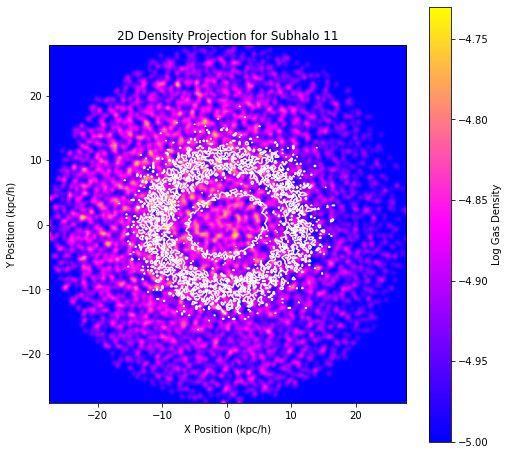

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
from tqdm import tqdm  # For progress bars

# Paths to the directories containing the HDF5 files
snapshot_dir = "/home/gs/Illustris_data/Snapshot-99/"
groupcat_dir = "/home/gs/Illustris_data/Group_catalog/"
snapshot_num = 99
subhalo_id = 11  # Adjust this to the subhalo ID you want to analyze

# Function to read all gas particle data
def read_all_gas_data(snapshot_dir, snapshot_num):
    gas_positions = []
    gas_densities = []
    
    snapshot_pattern = os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")
    snapshot_files = sorted(glob.glob(snapshot_pattern))
    print(f"Found {len(snapshot_files)} snapshot files for gas data.")
    
    for file_path in tqdm(snapshot_files, desc="Reading gas particle data"):
        with h5py.File(file_path, 'r') as f:
            if 'PartType0' in f:
                positions = f['PartType0/Coordinates'][:]
                densities = f['PartType0/Density'][:]
                gas_positions.append(positions)
                gas_densities.append(densities)
                print(f"Read {len(positions)} gas particles from {os.path.basename(file_path)}")
    if gas_positions:
        gas_positions = np.concatenate(gas_positions)
        gas_densities = np.concatenate(gas_densities)
    else:
        gas_positions = np.array([])
        gas_densities = np.array([])
    return gas_positions, gas_densities

# Function to read all star particle data
def read_all_star_data(snapshot_dir, snapshot_num):
    star_positions = []
    
    snapshot_pattern = os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")
    snapshot_files = sorted(glob.glob(snapshot_pattern))
    print(f"Found {len(snapshot_files)} snapshot files for star data.")
    
    for file_path in tqdm(snapshot_files, desc="Reading star particle data"):
        with h5py.File(file_path, 'r') as f:
            if 'PartType4' in f:
                positions = f['PartType4/Coordinates'][:]
                star_positions.append(positions)
                print(f"Read {len(positions)} star particles from {os.path.basename(file_path)}")
    if star_positions:
        star_positions = np.concatenate(star_positions)
    else:
        star_positions = np.array([])
    return star_positions

# Function to read all subhalo data
def read_all_subhalo_data(groupcat_dir, snapshot_num):
    subhalo_positions = []
    subhalo_half_mass_radii = []
    subhalo_masses = []

    groupcat_pattern = os.path.join(groupcat_dir, f"fof_subhalo_tab_{snapshot_num:03d}.*.hdf5")
    groupcat_files = sorted(glob.glob(groupcat_pattern))
    print(f"Found {len(groupcat_files)} group catalog files.")

    for file_path in tqdm(groupcat_files, desc="Reading subhalo data"):
        with h5py.File(file_path, 'r') as f:
            print(f"Inspecting file: {file_path}")
            print("Available groups:", list(f.keys()))

            if 'Subhalo' in f:
                subhalo_group = f['Subhalo']
                print("Datasets in 'Subhalo' group:", list(subhalo_group.keys()))

                # Adjust dataset names as needed
                if 'SubhaloPos' in subhalo_group:
                    subhalo_positions.append(subhalo_group['SubhaloPos'][:])
                else:
                    print(f"'SubhaloPos' not found in {file_path}")
                    continue

                if 'SubhaloHalfmassRadType' in subhalo_group:
                    subhalo_half_mass_radii.append(subhalo_group['SubhaloHalfmassRadType'][:, 4])  # Index 4 for stars
                else:
                    print(f"'SubhaloHalfmassRadType' not found in {file_path}")
                    continue

                if 'SubhaloMass' in subhalo_group:
                    subhalo_masses.append(subhalo_group['SubhaloMass'][:])
                else:
                    print(f"'SubhaloMass' not found in {file_path}")
                    continue
            else:
                print(f"'Subhalo' group not found in {file_path}")
                continue

    if subhalo_positions:
        subhalo_positions = np.concatenate(subhalo_positions)
        subhalo_half_mass_radii = np.concatenate(subhalo_half_mass_radii)
        subhalo_masses = np.concatenate(subhalo_masses)
    else:
        raise ValueError("No subhalo data found.")
    return subhalo_positions, subhalo_half_mass_radii, subhalo_masses


# Function to filter particles near the subhalo
def filter_particles(positions, subhalo_position, radius, box_size):
    delta = positions - subhalo_position
    delta = delta - box_size * np.round(delta / box_size)  # Periodic boundary conditions
    distances_squared = np.sum(delta**2, axis=1)
    within_radius = distances_squared < radius**2
    return delta[within_radius]

# Function to create and display a 2D density projection
def create_density_projection(gas_positions, gas_densities, star_positions, subhalo_id, resolution=200):
    if len(gas_positions) == 0 or len(gas_densities) == 0:
        print("No gas particles to project.")
        return
    if len(star_positions) == 0:
        print("No star particles to project.")
        return

    # Create gas density map
    proj, xedges, yedges = np.histogram2d(
        gas_positions[:, 0], gas_positions[:, 1],
        bins=resolution, weights=gas_densities)

    # Smooth the gas density map
    proj_smooth = gaussian_filter(proj, sigma=1.0)

    # Create stellar density map
    star_proj, _, _ = np.histogram2d(
        star_positions[:, 0], star_positions[:, 1],
        bins=[xedges, yedges])

    # Define custom colormap
    colors = ['blue', 'magenta', 'yellow']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Plot gas density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(proj_smooth.T + 1e-5), cmap=cmap, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               interpolation='bilinear')
    plt.colorbar(label='Log Gas Density')
    plt.xlabel('X Position (kpc/h)')
    plt.ylabel('Y Position (kpc/h)')
    plt.title(f'2D Density Projection for Subhalo {subhalo_id}')

    # Add stellar contours
    if np.any(star_proj > 0):
        levels = np.percentile(star_proj[star_proj > 0], [75, 85, 95])  # Adjust as needed
        plt.contour(star_proj.T, levels=levels, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white', linewidths=1.5)
    else:
        print("No stellar particles found in the projection.")

    plt.show()

# Main execution
if __name__ == "__main__":
    # Read all subhalo data first to get the galaxy position
    subhalo_positions, subhalo_half_mass_radii, subhalo_masses = read_all_subhalo_data(groupcat_dir, snapshot_num)

    # Get the subhalo data for your subhalo_id
    if subhalo_id >= len(subhalo_positions):
        raise ValueError(f"Subhalo ID {subhalo_id} is out of range. Maximum ID is {len(subhalo_positions) - 1}.")

    subhalo_position = subhalo_positions[subhalo_id]
    subhalo_radius = subhalo_half_mass_radii[subhalo_id]
    subhalo_mass = subhalo_masses[subhalo_id]

    # Simulation box size (in kpc/h)
    with h5py.File(glob.glob(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.0.hdf5"))[0], 'r') as f:
        header = dict(f['Header'].attrs.items())
        box_size = header['BoxSize']

    # Display basic subhalo info
    print(f"\nSubhalo ID: {subhalo_id}")
    print(f"Subhalo Position: {subhalo_position}")
    print(f"Subhalo Radius: {subhalo_radius}")
    print(f"Subhalo Mass: {subhalo_mass}")
    print(f"Simulation Box Size: {box_size}\n")

    # Choose a smaller radius for focusing on a single galaxy (subhalo) in a smaller box
    small_radius = subhalo_radius * 5  # Adjust multiplier as needed
    print(f"Filtering particles within radius: {small_radius} kpc/h\n")

    # Read and filter gas particles incrementally
    gas_positions_filtered = []
    gas_densities_filtered = []

    snapshot_pattern = os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")
    snapshot_files = sorted(glob.glob(snapshot_pattern))
    print(f"Processing gas particles from {len(snapshot_files)} snapshot files.")

    for file_path in tqdm(snapshot_files, desc="Filtering gas particles"):
        with h5py.File(file_path, 'r') as f:
            if 'PartType0' in f:
                positions = f['PartType0/Coordinates'][:]
                densities = f['PartType0/Density'][:]
                # Filter particles near the subhalo
                filtered_positions = filter_particles(positions, subhalo_position, small_radius, box_size)
                delta = positions - subhalo_position
                delta = delta - box_size * np.round(delta / box_size)
                distances_squared = np.sum(delta**2, axis=1)
                within_radius = distances_squared < small_radius**2
                filtered_densities = densities[within_radius]
                gas_positions_filtered.append(filtered_positions)
                gas_densities_filtered.append(filtered_densities)
                print(f"Filtered {len(filtered_positions)} gas particles from {os.path.basename(file_path)}")

    if gas_positions_filtered:
        gas_positions_filtered = np.concatenate(gas_positions_filtered)
        gas_densities_filtered = np.concatenate(gas_densities_filtered)
    else:
        gas_positions_filtered = np.array([])
        gas_densities_filtered = np.array([])

    # Read and filter star particles incrementally
    star_positions_filtered = []

    print(f"\nProcessing star particles from {len(snapshot_files)} snapshot files.")

    for file_path in tqdm(snapshot_files, desc="Filtering star particles"):
        with h5py.File(file_path, 'r') as f:
            if 'PartType4' in f:
                positions = f['PartType4/Coordinates'][:]
                # Filter particles near the subhalo
                filtered_positions = filter_particles(positions, subhalo_position, small_radius, box_size)
                star_positions_filtered.append(filtered_positions)
                print(f"Filtered {len(filtered_positions)} star particles from {os.path.basename(file_path)}")

    if star_positions_filtered:
        star_positions_filtered = np.concatenate(star_positions_filtered)
    else:
        star_positions_filtered = np.array([])

    print(f"\nNumber of gas particles selected: {len(gas_positions_filtered)}")
    print(f"Number of star particles selected: {len(star_positions_filtered)}\n")

    # Create a 2D density projection of the gas particles, with stellar contours
    create_density_projection(gas_positions_filtered, gas_densities_filtered, star_positions_filtered, subhalo_id, resolution=200)


In [7]:




def read_all_subhalo_data(groupcat_dir, snapshot_num):
    """
    Reads subhalo data from group catalog files.

    Parameters:
    - groupcat_dir: Directory containing the group catalog files.
    - snapshot_num: Snapshot number to read.

    Returns:
    - subhalo_positions: Array of subhalo positions.
    - subhalo_half_mass_radii: Array of subhalo half-mass radii.
    - subhalo_masses: Array of subhalo masses.
    """
    # Initialize lists to store data
    subhalo_positions = []
    subhalo_half_mass_radii = []
    subhalo_masses = []

    # Find all group catalog files for the snapshot
    groupcat_pattern = os.path.join(groupcat_dir, f"fof_subhalo_tab_{snapshot_num:03d}.*.hdf5")
    groupcat_files = sorted(glob.glob(groupcat_pattern))
    logging.info(f"Found {len(groupcat_files)} group catalog files.")

    # Read data from each file
    for file_path in tqdm(groupcat_files, desc="Reading subhalo data"):
        with h5py.File(file_path, 'r') as f:
            if 'Subhalo' in f:
                subhalo_group = f['Subhalo']
                # Check if 'SubhaloMass' exists (since 'SubhaloPos' might be missing)
                if 'SubhaloMass' in subhalo_group:
                    masses = subhalo_group['SubhaloMass'][:]
                    subhalo_masses.append(masses)
                    # Read positions if available
                    if 'SubhaloPos' in subhalo_group:
                        positions = subhalo_group['SubhaloPos'][:]
                    else:
                        positions = np.zeros((len(masses), 3))
                        logging.warning(f"'SubhaloPos' not found in {file_path}, filling with zeros.")
                    subhalo_positions.append(positions)
                    # Read half-mass radii if available
                    if 'SubhaloHalfmassRadType' in subhalo_group:
                        half_mass_radii = subhalo_group['SubhaloHalfmassRadType'][:, 4]  # Index 4 for stars
                    else:
                        half_mass_radii = np.zeros(len(masses))
                        logging.warning(f"'SubhaloHalfmassRadType' not found in {file_path}, filling with zeros.")
                    subhalo_half_mass_radii.append(half_mass_radii)
                else:
                    logging.warning(f"'SubhaloMass' not found in {file_path}")
            else:
                logging.warning(f"'Subhalo' group not found in {file_path}")
                continue

    # Concatenate data from all files
    if subhalo_masses:
        subhalo_positions = np.concatenate(subhalo_positions)
        subhalo_half_mass_radii = np.concatenate(subhalo_half_mass_radii)
        subhalo_masses = np.concatenate(subhalo_masses)
    else:
        logging.error("No subhalo masses found in any group catalog files.")
        return None, None, None

    return subhalo_positions, subhalo_half_mass_radii, subhalo_masses


def filter_particles(positions, subhalo_position, radius, box_size):
    """
    Filters particles within a specified radius around a subhalo.

    Parameters:
    - positions: Positions of particles.
    - subhalo_position: Position of the subhalo.
    - radius: Radius within which to filter particles.
    - box_size: Size of the simulation box (for periodic boundaries).

    Returns:
    - Positions of particles within the specified radius.
    """
    delta = positions - subhalo_position
    delta = delta - box_size * np.round(delta / box_size)  # Periodic boundary conditions
    distances_squared = np.sum(delta**2, axis=1)
    within_radius = distances_squared < radius**2
    return delta[within_radius]

def create_density_projection(gas_positions, gas_densities, star_positions, subhalo_id, output_dir, resolution=200):
    """
    Creates and saves a 2D density projection image for a subhalo.

    Parameters:
    - gas_positions: Positions of gas particles.
    - gas_densities: Densities of gas particles.
    - star_positions: Positions of star particles.
    - subhalo_id: ID of the subhalo.
    - output_dir: Directory to save the output image.
    - resolution: Resolution of the density grid.
    """
    if len(gas_positions) == 0 or len(gas_densities) == 0:
        logging.warning(f"No gas particles to project for Subhalo {subhalo_id}.")
        return
    if len(star_positions) == 0:
        logging.warning(f"No star particles to project for Subhalo {subhalo_id}.")
        return

    # Create gas density map
    proj, xedges, yedges = np.histogram2d(
        gas_positions[:, 0], gas_positions[:, 1],
        bins=resolution, weights=gas_densities)

    # Smooth the gas density map
    proj_smooth = gaussian_filter(proj, sigma=1.0)

    # Create stellar density map
    star_proj, _, _ = np.histogram2d(
        star_positions[:, 0], star_positions[:, 1],
        bins=[xedges, yedges])

    # Define custom colormap
    colors = ['blue', 'magenta', 'yellow']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Plot gas density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(proj_smooth.T + 1e-5), cmap=cmap, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               interpolation='bilinear')
    plt.colorbar(label='Log Gas Density')
    plt.xlabel('X Position (kpc/h)')
    plt.ylabel('Y Position (kpc/h)')
    plt.title(f'2D Density Projection for Subhalo {subhalo_id}')

    # Add stellar contours
    if np.any(star_proj > 0):
        levels = np.percentile(star_proj[star_proj > 0], [75, 85, 95])
        plt.contour(star_proj.T, levels=levels, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white', linewidths=1.5)
    else:
        logging.warning(f"No stellar particles found in the projection for Subhalo {subhalo_id}.")

    # Save the plot
    output_file = os.path.join(output_dir, f'subhalo_{subhalo_id}_density_projection.png')
    plt.savefig(output_file)
    plt.close()
    logging.info(f"Saved density projection for Subhalo {subhalo_id} to {output_file}")

if __name__ == "__main__":
    # Paths to data directories
    snapshot_dir = "/home/gs/Illustris_data/Snapshot-99/"
    groupcat_dir = "/home/gs/Illustris_data/Group_catalog/"
    snapshot_num = 99
    output_dir = "./density_projections"  # Directory to save the images
    os.makedirs(output_dir, exist_ok=True)

    # Read all subhalo data
    subhalo_positions, subhalo_half_mass_radii, subhalo_masses = read_all_subhalo_data(groupcat_dir, snapshot_num)

    # Check if subhalo data was successfully read
    if subhalo_masses is None:
        logging.error("Failed to read subhalo masses. Exiting.")
        exit()

    # Print statistics of subhalo masses
    print(f"Subhalo masses: min={np.min(subhalo_masses)}, max={np.max(subhalo_masses)}")
    print(f"First few subhalo masses: {subhalo_masses[:10]}")

    # Set mass threshold for selecting massive subhalos
    mass_threshold = 1.0  # Adjusted threshold based on units

    # Select subhalos with mass greater than the threshold
    massive_subhalo_indices = np.where(subhalo_masses > mass_threshold)[0]
    logging.info(f"Found {len(massive_subhalo_indices)} subhalos with mass greater than {mass_threshold}")

    # Get simulation box size
    with h5py.File(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.0.hdf5"), 'r') as f:
        header = dict(f['Header'].attrs.items())
        box_size = header['BoxSize']

    # List all snapshot files
    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")))
    logging.info(f"Found {len(snapshot_files)} snapshot files.")

    # Loop over selected subhalos
    for subhalo_id in tqdm(massive_subhalo_indices, desc="Processing subhalos"):
        subhalo_position = subhalo_positions[subhalo_id]
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]
        subhalo_mass = subhalo_masses[subhalo_id]

        # Define the radius to filter particles (e.g., 5 times the half-mass radius)
        small_radius = subhalo_radius * 5  # Adjust as needed

        logging.info(f"Subhalo ID: {subhalo_id}")
        logging.info(f"Subhalo Position: {subhalo_position}")
        logging.info(f"Subhalo Radius: {subhalo_radius}")
        logging.info(f"Subhalo Mass: {subhalo_mass}")
        logging.info(f"Filtering particles within radius: {small_radius} kpc/h")

        # Initialize lists to store filtered particles
        gas_positions_filtered = []
        gas_densities_filtered = []
        star_positions_filtered = []

        # Read and filter gas particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType0' in f:
                    positions = f['PartType0/Coordinates'][:]
                    densities = f['PartType0/Density'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    filtered_densities = densities[within_radius]
                    if len(filtered_positions) > 0:
                        gas_positions_filtered.append(filtered_positions)
                        gas_densities_filtered.append(filtered_densities)

        # Concatenate filtered gas particles
        if gas_positions_filtered:
            gas_positions_filtered = np.concatenate(gas_positions_filtered)
            gas_densities_filtered = np.concatenate(gas_densities_filtered)
        else:
            gas_positions_filtered = np.array([])
            gas_densities_filtered = np.array([])

        # Read and filter star particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType4' in f:
                    positions = f['PartType4/Coordinates'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    if len(filtered_positions) > 0:
                        star_positions_filtered.append(filtered_positions)

        # Concatenate filtered star particles
        if star_positions_filtered:
            star_positions_filtered = np.concatenate(star_positions_filtered)
        else:
            star_positions_filtered = np.array([])

        # Check if we have enough particles to proceed
        if len(gas_positions_filtered) == 0 and len(star_positions_filtered) == 0:
            logging.warning(f"No gas or star particles found for Subhalo {subhalo_id} within radius {small_radius}")
            continue

        # Create density projection
        create_density_projection(
            gas_positions_filtered, 
            gas_densities_filtered, 
            star_positions_filtered, 
            subhalo_id, 
            output_dir,
            resolution=200
        )


INFO:root:Found 448 group catalog files.
Reading subhalo data: 100%|██████████| 448/448 [00:01<00:00, 328.92it/s]
INFO:root:Found 99678 subhalos with mass greater than 1.0
INFO:root:Found 448 snapshot files.


Subhalo masses: min=0.0008295169682241976, max=27477.935546875
First few subhalo masses: [27477.936    3666.6228    773.4555    339.1331    325.3667    298.01813
   206.83061   137.82588   118.54483   129.09142]


Processing subhalos:   0%|          | 0/99678 [00:00<?, ?it/s]INFO:root:Subhalo ID: 0
INFO:root:Subhalo Position: [  849.09143 26326.996   18306.934  ]
INFO:root:Subhalo Radius: 47.388057708740234
INFO:root:Subhalo Mass: 27477.935546875
INFO:root:Filtering particles within radius: 236.94028854370117 kpc/h
Processing subhalos:   0%|          | 0/99678 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
from tqdm import tqdm  # For progress bars
import logging

# Set up logging to control output verbosity
logging.basicConfig(level=logging.INFO)

def read_all_subhalo_data(groupcat_dir, snapshot_num):
    """
    Reads subhalo data from group catalog files.

    Parameters:
    - groupcat_dir: Directory containing the group catalog files.
    - snapshot_num: Snapshot number to read.

    Returns:
    - subhalo_positions: Array of subhalo positions.
    - subhalo_half_mass_radii: Array of subhalo half-mass radii.
    - subhalo_masses: Array of subhalo masses.
    """
    # Initialize lists to store data
    subhalo_positions = []
    subhalo_half_mass_radii = []
    subhalo_masses = []

    # Find all group catalog files for the snapshot
    groupcat_pattern = os.path.join(groupcat_dir, f"fof_subhalo_tab_{snapshot_num:03d}.*.hdf5")
    groupcat_files = sorted(glob.glob(groupcat_pattern))
    logging.info(f"Found {len(groupcat_files)} group catalog files.")

    # Read data from each file
    for file_path in tqdm(groupcat_files, desc="Reading subhalo data"):
        with h5py.File(file_path, 'r') as f:
            if 'Subhalo' in f:
                subhalo_group = f['Subhalo']
                # Check if 'SubhaloMass' exists (since 'SubhaloPos' might be missing)
                if 'SubhaloMass' in subhalo_group:
                    masses = subhalo_group['SubhaloMass'][:]
                    subhalo_masses.append(masses)
                    # Read positions if available
                    if 'SubhaloPos' in subhalo_group:
                        positions = subhalo_group['SubhaloPos'][:]
                    else:
                        positions = np.zeros((len(masses), 3))
                        logging.warning(f"'SubhaloPos' not found in {file_path}, filling with zeros.")
                    subhalo_positions.append(positions)
                    # Read half-mass radii if available
                    if 'SubhaloHalfmassRadType' in subhalo_group:
                        half_mass_radii = subhalo_group['SubhaloHalfmassRadType'][:, 4]  # Index 4 for stars
                    else:
                        half_mass_radii = np.zeros(len(masses))
                        logging.warning(f"'SubhaloHalfmassRadType' not found in {file_path}, filling with zeros.")
                    subhalo_half_mass_radii.append(half_mass_radii)
                else:
                    logging.warning(f"'SubhaloMass' not found in {file_path}")
            else:
                logging.warning(f"'Subhalo' group not found in {file_path}")
                continue

    # Concatenate data from all files
    if subhalo_masses:
        subhalo_positions = np.concatenate(subhalo_positions)
        subhalo_half_mass_radii = np.concatenate(subhalo_half_mass_radii)
        subhalo_masses = np.concatenate(subhalo_masses)
    else:
        logging.error("No subhalo masses found in any group catalog files.")
        return None, None, None

    return subhalo_positions, subhalo_half_mass_radii, subhalo_masses


def filter_particles(positions, subhalo_position, radius, box_size):
    """
    Filters particles within a specified radius around a subhalo.

    Parameters:
    - positions: Positions of particles.
    - subhalo_position: Position of the subhalo.
    - radius: Radius within which to filter particles.
    - box_size: Size of the simulation box (for periodic boundaries).

    Returns:
    - Positions of particles within the specified radius.
    """
    delta = positions - subhalo_position
    delta = delta - box_size * np.round(delta / box_size)  # Periodic boundary conditions
    distances_squared = np.sum(delta**2, axis=1)
    within_radius = distances_squared < radius**2
    return delta[within_radius]


def create_density_projection(gas_positions, gas_densities, star_positions, subhalo_id, output_dir, resolution=200):
    """
    Creates and saves a 2D density projection image for a subhalo.

    Parameters:
    - gas_positions: Positions of gas particles.
    - gas_densities: Densities of gas particles.
    - star_positions: Positions of star particles.
    - subhalo_id: ID of the subhalo.
    - output_dir: Directory to save the output image.
    - resolution: Resolution of the density grid.
    """
    if len(gas_positions) == 0 or len(gas_densities) == 0:
        logging.warning(f"No gas particles to project for Subhalo {subhalo_id}.")
        return
    if len(star_positions) == 0:
        logging.warning(f"No star particles to project for Subhalo {subhalo_id}.")
        return

    # Create gas density map
    proj, xedges, yedges = np.histogram2d(
        gas_positions[:, 0], gas_positions[:, 1],
        bins=resolution, weights=gas_densities)

    # Smooth the gas density map
    proj_smooth = gaussian_filter(proj, sigma=1.0)

    # Create stellar density map
    star_proj, _, _ = np.histogram2d(
        star_positions[:, 0], star_positions[:, 1],
        bins=[xedges, yedges])

    # Define custom colormap
    colors = ['blue', 'magenta', 'yellow']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Plot gas density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(proj_smooth.T + 1e-5), cmap=cmap, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               interpolation='bilinear')
    plt.colorbar(label='Log Gas Density')
    plt.xlabel('X Position (kpc/h)')
    plt.ylabel('Y Position (kpc/h)')
    plt.title(f'2D Density Projection for Subhalo {subhalo_id}')

    # Add stellar contours
    if np.any(star_proj > 0):
        levels = np.percentile(star_proj[star_proj > 0], [75, 85, 95])
        plt.contour(star_proj.T, levels=levels, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white', linewidths=1.5)
    else:
        logging.warning(f"No stellar particles found in the projection for Subhalo {subhalo_id}.")

    # Save the plot
    output_file = os.path.join(output_dir, f'subhalo_{subhalo_id}_density_projection.png')
    plt.savefig(output_file)
    plt.close()
    logging.info(f"Saved density projection for Subhalo {subhalo_id} to {output_file}")


if __name__ == "__main__":
    # Paths to data directories
    snapshot_dir = "/home/gs/Illustris_data/Snapshot-99/"
    groupcat_dir = "/home/gs/Illustris_data/Group_catalog/"
    snapshot_num = 99
    output_dir = "./density_projections"  # Directory to save the images
    os.makedirs(output_dir, exist_ok=True)
    default_radius = 5.0  # Default radius in kpc/h

    # Read all subhalo data
    subhalo_positions, subhalo_half_mass_radii, subhalo_masses = read_all_subhalo_data(groupcat_dir, snapshot_num)

    # Check if subhalo data was successfully read
    if subhalo_masses is None:
        logging.error("Failed to read subhalo masses. Exiting.")
        exit()

    # Print statistics of subhalo masses
    print(f"Subhalo masses: min={np.min(subhalo_masses)}, max={np.max(subhalo_masses)}")
    print(f"First few subhalo masses: {subhalo_masses[:10]}")

    # Set mass threshold for selecting massive subhalos
    # Adjust the mass_threshold based on the units and values of subhalo_masses
    mass_threshold = 1.0  # Adjusted threshold based on units

    # Select subhalos with mass greater than the threshold
    massive_subhalo_indices = np.where(subhalo_masses > mass_threshold)[0]
    logging.info(f"Found {len(massive_subhalo_indices)} subhalos with mass greater than {mass_threshold}")

    # Get simulation box size
    with h5py.File(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.0.hdf5"), 'r') as f:
        header = dict(f['Header'].attrs.items())
        box_size = header['BoxSize']

    # List all snapshot files
    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")))
    logging.info(f"Found {len(snapshot_files)} snapshot files.")

    # Loop over selected subhalos
    for subhalo_id in tqdm(massive_subhalo_indices, desc="Processing subhalos"):
        subhalo_position = subhalo_positions[subhalo_id]
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]
        subhalo_mass = subhalo_masses[subhalo_id]

        # Handle zero radius
        if subhalo_radius == 0:
            subhalo_radius = default_radius
            logging.warning(f"Subhalo {subhalo_id} has zero radius, setting to default value {default_radius} kpc/h")

        # Define the radius to filter particles (e.g., 5 times the half-mass radius)
        small_radius = subhalo_radius * 5  # Adjust as needed

        logging.info(f"Subhalo ID: {subhalo_id}")
        logging.info(f"Subhalo Position: {subhalo_position}")
        logging.info(f"Subhalo Radius: {subhalo_radius}")
        logging.info(f"Subhalo Mass: {subhalo_mass}")
        logging.info(f"Filtering particles within radius: {small_radius} kpc/h")

        # Initialize lists to store filtered particles
        gas_positions_filtered = []
        gas_densities_filtered = []
        star_positions_filtered = []

        # Read and filter gas particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType0' in f:
                    positions = f['PartType0/Coordinates'][:]
                    densities = f['PartType0/Density'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    filtered_densities = densities[within_radius]
                    if len(filtered_positions) > 0:
                        gas_positions_filtered.append(filtered_positions)
                        gas_densities_filtered.append(filtered_densities)

        # Concatenate filtered gas particles
        if gas_positions_filtered:
            gas_positions_filtered = np.concatenate(gas_positions_filtered)
            gas_densities_filtered = np.concatenate(gas_densities_filtered)
        else:
            gas_positions_filtered = np.array([])
            gas_densities_filtered = np.array([])

        # Read and filter star particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType4' in f:
                    positions = f['PartType4/Coordinates'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    if len(filtered_positions) > 0:
                        star_positions_filtered.append(filtered_positions)

        # Concatenate filtered star particles
        if star_positions_filtered:
            star_positions_filtered = np.concatenate(star_positions_filtered)
        else:
            star_positions_filtered = np.array([])

        # Check if we have enough particles to proceed
        if len(gas_positions_filtered) == 0 and len(star_positions_filtered) == 0:
            logging.warning(f"No gas or star particles found for Subhalo {subhalo_id} within radius {small_radius}")
            continue

        # Create density projection
        create_density_projection(
            gas_positions_filtered,
            gas_densities_filtered,
            star_positions_filtered,
            subhalo_id,
            output_dir,
            resolution=200
        )


INFO:root:Found 448 group catalog files.
Reading subhalo data: 100%|██████████| 448/448 [00:01<00:00, 343.42it/s]
INFO:root:Found 99678 subhalos with mass greater than 1.0
INFO:root:Found 448 snapshot files.


Subhalo masses: min=0.0008295169682241976, max=27477.935546875
First few subhalo masses: [27477.936    3666.6228    773.4555    339.1331    325.3667    298.01813
   206.83061   137.82588   118.54483   129.09142]


Processing subhalos:   0%|          | 0/99678 [00:00<?, ?it/s]INFO:root:Subhalo ID: 0
INFO:root:Subhalo Position: [  849.09143 26326.996   18306.934  ]
INFO:root:Subhalo Radius: 47.388057708740234
INFO:root:Subhalo Mass: 27477.935546875
INFO:root:Filtering particles within radius: 236.94028854370117 kpc/h
Processing subhalos:   0%|          | 0/99678 [06:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
from tqdm import tqdm  # For progress bars
import logging

# Set up logging to control output verbosity
logging.basicConfig(level=logging.INFO)

def read_all_subhalo_data(groupcat_dir, snapshot_num):
    """
    Reads subhalo data from group catalog files.

    Parameters:
    - groupcat_dir: Directory containing the group catalog files.
    - snapshot_num: Snapshot number to read.

    Returns:
    - subhalo_positions: Array of subhalo positions.
    - subhalo_half_mass_radii: Array of subhalo half-mass radii.
    - subhalo_masses: Array of subhalo masses.
    """
    # Initialize lists to store data
    subhalo_positions = []
    subhalo_half_mass_radii = []
    subhalo_masses = []

    # Find all group catalog files for the snapshot
    groupcat_pattern = os.path.join(groupcat_dir, f"fof_subhalo_tab_{snapshot_num:03d}.*.hdf5")
    groupcat_files = sorted(glob.glob(groupcat_pattern))
    logging.info(f"Found {len(groupcat_files)} group catalog files.")

    # Read data from each file
    for file_path in tqdm(groupcat_files, desc="Reading subhalo data"):
        with h5py.File(file_path, 'r') as f:
            if 'Subhalo' in f:
                subhalo_group = f['Subhalo']
                # Check if 'SubhaloMass' exists (since 'SubhaloPos' might be missing)
                if 'SubhaloMass' in subhalo_group:
                    masses = subhalo_group['SubhaloMass'][:]
                    subhalo_masses.append(masses)
                    # Read positions if available
                    if 'SubhaloPos' in subhalo_group:
                        positions = subhalo_group['SubhaloPos'][:]
                    else:
                        positions = np.zeros((len(masses), 3))
                        logging.warning(f"'SubhaloPos' not found in {file_path}, filling with zeros.")
                    subhalo_positions.append(positions)
                    # Read half-mass radii if available
                    if 'SubhaloHalfmassRadType' in subhalo_group:
                        half_mass_radii = subhalo_group['SubhaloHalfmassRadType'][:, 4]  # Index 4 for stars
                    else:
                        half_mass_radii = np.zeros(len(masses))
                        logging.warning(f"'SubhaloHalfmassRadType' not found in {file_path}, filling with zeros.")
                    subhalo_half_mass_radii.append(half_mass_radii)
                else:
                    logging.warning(f"'SubhaloMass' not found in {file_path}")
            else:
                logging.warning(f"'Subhalo' group not found in {file_path}")
                continue

    # Concatenate data from all files
    if subhalo_masses:
        subhalo_positions = np.concatenate(subhalo_positions)
        subhalo_half_mass_radii = np.concatenate(subhalo_half_mass_radii)
        subhalo_masses = np.concatenate(subhalo_masses)
    else:
        logging.error("No subhalo masses found in any group catalog files.")
        return None, None, None

    return subhalo_positions, subhalo_half_mass_radii, subhalo_masses


def filter_particles(positions, subhalo_position, radius, box_size):
    """
    Filters particles within a specified radius around a subhalo.

    Parameters:
    - positions: Positions of particles.
    - subhalo_position: Position of the subhalo.
    - radius: Radius within which to filter particles.
    - box_size: Size of the simulation box (for periodic boundaries).

    Returns:
    - Positions of particles within the specified radius.
    """
    delta = positions - subhalo_position
    delta = delta - box_size * np.round(delta / box_size)  # Periodic boundary conditions
    distances_squared = np.sum(delta**2, axis=1)
    within_radius = distances_squared < radius**2
    return delta[within_radius]


def create_density_projection(gas_positions, gas_densities, star_positions, subhalo_id, output_dir, resolution=200):
    """
    Creates and saves a 2D density projection image for a subhalo.

    Parameters:
    - gas_positions: Positions of gas particles.
    - gas_densities: Densities of gas particles.
    - star_positions: Positions of star particles.
    - subhalo_id: ID of the subhalo.
    - output_dir: Directory to save the output image.
    - resolution: Resolution of the density grid.
    """
    if len(gas_positions) == 0 or len(gas_densities) == 0:
        logging.warning(f"No gas particles to project for Subhalo {subhalo_id}.")
        return
    if len(star_positions) == 0:
        logging.warning(f"No star particles to project for Subhalo {subhalo_id}.")
        return

    # Create gas density map
    proj, xedges, yedges = np.histogram2d(
        gas_positions[:, 0], gas_positions[:, 1],
        bins=resolution, weights=gas_densities)

    # Smooth the gas density map
    proj_smooth = gaussian_filter(proj, sigma=1.0)

    # Create stellar density map
    star_proj, _, _ = np.histogram2d(
        star_positions[:, 0], star_positions[:, 1],
        bins=[xedges, yedges])

    # Define custom colormap
    colors = ['blue', 'magenta', 'yellow']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Plot gas density map
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log10(proj_smooth.T + 1e-5), cmap=cmap, origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               interpolation='bilinear')
    plt.colorbar(label='Log Gas Density')
    plt.xlabel('X Position (kpc/h)')
    plt.ylabel('Y Position (kpc/h)')
    plt.title(f'2D Density Projection for Subhalo {subhalo_id}')

    # Add stellar contours
    if np.any(star_proj > 0):
        levels = np.percentile(star_proj[star_proj > 0], [75, 85, 95])
        plt.contour(star_proj.T, levels=levels, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    colors='white', linewidths=1.5)
    else:
        logging.warning(f"No stellar particles found in the projection for Subhalo {subhalo_id}.")

    # Save the plot
    output_file = os.path.join(output_dir, f'subhalo_{subhalo_id}_density_projection.png')
    plt.savefig(output_file)
    plt.close()
    logging.info(f"Saved density projection for Subhalo {subhalo_id} to {output_file}")


if __name__ == "__main__":
    # Paths to data directories
    snapshot_dir = "/home/gs/Illustris_data/Snapshot-99/"
    groupcat_dir = "/home/gs/Illustris_data/Group_catalog/"
    snapshot_num = 99
    output_dir = "./density_projections_V1"  # Directory to save the images
    os.makedirs(output_dir, exist_ok=True)
    default_radius = 5.0  # Default radius in kpc/h

    # Read all subhalo data
    subhalo_positions, subhalo_half_mass_radii, subhalo_masses = read_all_subhalo_data(groupcat_dir, snapshot_num)

    # Check if subhalo data was successfully read
    if subhalo_masses is None:
        logging.error("Failed to read subhalo masses. Exiting.")
        exit()

    # Print statistics of subhalo masses
    print(f"Subhalo masses: min={np.min(subhalo_masses)}, max={np.max(subhalo_masses)}")
    print(f"First few subhalo masses: {subhalo_masses[:10]}")

    # Set mass threshold for selecting massive subhalos
    mass_threshold = 1.0  # Adjusted threshold based on units

    # Select subhalos with mass greater than the threshold
    massive_subhalo_indices = np.where(subhalo_masses > mass_threshold)[0]
    logging.info(f"Found {len(massive_subhalo_indices)} subhalos with mass greater than {mass_threshold}")

    # Sort the subhalos by mass in descending order
    sorted_indices = np.argsort(subhalo_masses[massive_subhalo_indices])[::-1]
    massive_subhalo_indices = massive_subhalo_indices[sorted_indices]

    # Limit to top N subhalos
    N = 100  # Adjust N as needed
    massive_subhalo_indices = massive_subhalo_indices[:N]
    logging.info(f"Processing the top {N} most massive subhalos.")

    # Get simulation box size
    with h5py.File(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.0.hdf5"), 'r') as f:
        header = dict(f['Header'].attrs.items())
        box_size = header['BoxSize']

    # List all snapshot files
    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, f"snap_{snapshot_num:03d}.*.hdf5")))
    logging.info(f"Found {len(snapshot_files)} snapshot files.")

    # Loop over selected subhalos
    for subhalo_id in tqdm(massive_subhalo_indices, desc="Processing subhalos"):
        subhalo_position = subhalo_positions[subhalo_id]
        subhalo_radius = subhalo_half_mass_radii[subhalo_id]
        subhalo_mass = subhalo_masses[subhalo_id]

        # Handle zero radius
        if subhalo_radius == 0:
            subhalo_radius = default_radius
            logging.warning(f"Subhalo {subhalo_id} has zero radius, setting to default value {default_radius} kpc/h")

        # Define the radius to filter particles (e.g., 2 times the half-mass radius)
        small_radius = subhalo_radius * 2  # Adjust as needed

        logging.info(f"Subhalo ID: {subhalo_id}")
        logging.info(f"Subhalo Position: {subhalo_position}")
        logging.info(f"Subhalo Radius: {subhalo_radius}")
        logging.info(f"Subhalo Mass: {subhalo_mass}")
        logging.info(f"Filtering particles within radius: {small_radius} kpc/h")

        # Initialize lists to store filtered particles
        gas_positions_filtered = []
        gas_densities_filtered = []
        star_positions_filtered = []

        # Read and filter gas particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType0' in f:
                    positions = f['PartType0/Coordinates'][:]
                    densities = f['PartType0/Density'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    filtered_densities = densities[within_radius]
                    if len(filtered_positions) > 0:
                        gas_positions_filtered.append(filtered_positions)
                        gas_densities_filtered.append(filtered_densities)

        # Concatenate filtered gas particles
        if gas_positions_filtered:
            gas_positions_filtered = np.concatenate(gas_positions_filtered)
            gas_densities_filtered = np.concatenate(gas_densities_filtered)
        else:
            gas_positions_filtered = np.array([])
            gas_densities_filtered = np.array([])

        # Read and filter star particles
        for file_path in snapshot_files:
            with h5py.File(file_path, 'r') as f:
                if 'PartType4' in f:
                    positions = f['PartType4/Coordinates'][:]
                    # Filter particles
                    delta = positions - subhalo_position
                    delta = delta - box_size * np.round(delta / box_size)
                    distances_squared = np.sum(delta**2, axis=1)
                    within_radius = distances_squared < small_radius**2
                    filtered_positions = delta[within_radius]
                    if len(filtered_positions) > 0:
                        star_positions_filtered.append(filtered_positions)

        # Concatenate filtered star particles
        if star_positions_filtered:
            star_positions_filtered = np.concatenate(star_positions_filtered)
        else:
            star_positions_filtered = np.array([])

        # Check if we have enough particles to proceed
        if len(gas_positions_filtered) == 0 and len(star_positions_filtered) == 0:
            logging.warning(f"No gas or star particles found for Subhalo {subhalo_id} within radius {small_radius}")
            continue

        # Create density projection
        create_density_projection(
            gas_positions_filtered,
            gas_densities_filtered,
            star_positions_filtered,
            subhalo_id,
            output_dir,
            resolution=200
        )


INFO:root:Found 448 group catalog files.
Reading subhalo data: 100%|██████████| 448/448 [00:28<00:00, 15.56it/s]
INFO:root:Found 99678 subhalos with mass greater than 1.0
INFO:root:Processing the top 100 most massive subhalos.
INFO:root:Found 448 snapshot files.


Subhalo masses: min=0.0008295169682241976, max=27477.935546875
First few subhalo masses: [27477.936    3666.6228    773.4555    339.1331    325.3667    298.01813
   206.83061   137.82588   118.54483   129.09142]


Processing subhalos:   0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Subhalo ID: 0
INFO:root:Subhalo Position: [  849.09143 26326.996   18306.934  ]
INFO:root:Subhalo Radius: 47.388057708740234
INFO:root:Subhalo Mass: 27477.935546875
INFO:root:Filtering particles within radius: 94.77611541748047 kpc/h
INFO:root:Saved density projection for Subhalo 0 to ./density_projections_V1/subhalo_0_density_projection.png
Processing subhalos:   1%|          | 1/100 [12:29<20:36:26, 749.36s/it]INFO:root:Subhalo ID: 4282524
INFO:root:Subhalo Position: [19755.348 47554.965 48920.637]
INFO:root:Subhalo Radius: 88.33854675292969
INFO:root:Subhalo Mass: 27463.623046875
INFO:root:Filtering particles within radius: 176.67709350585938 kpc/h
INFO:root:Saved density projection for Subhalo 4282524 to ./density_projections_V1/subhalo_4282524_density_projection.png
Processing subhalos:   2%|▏         | 2/100 [25:03<20:28:06, 751.90s/it]INFO:root:Subhalo ID: 69507
INFO:root:Subhalo Position: [10900.232 50857.914

INFO:root:Saved density projection for Subhalo 4259247 to ./density_projections_V1/subhalo_4259247_density_projection.png
Processing subhalos:  19%|█▉        | 19/100 [3:55:55<16:46:07, 745.27s/it]INFO:root:Subhalo ID: 4265246
INFO:root:Subhalo Position: [39278.4   21708.78  47328.605]
INFO:root:Subhalo Radius: 23.30916976928711
INFO:root:Subhalo Mass: 5675.87109375
INFO:root:Filtering particles within radius: 46.61833953857422 kpc/h
INFO:root:Saved density projection for Subhalo 4265246 to ./density_projections_V1/subhalo_4265246_density_projection.png
Processing subhalos:  20%|██        | 20/100 [4:08:21<16:33:57, 745.46s/it]INFO:root:Subhalo ID: 4262083
INFO:root:Subhalo Position: [13502.055 53243.844 68550.06 ]
INFO:root:Subhalo Radius: 22.40386390686035
INFO:root:Subhalo Mass: 5262.2978515625
INFO:root:Filtering particles within radius: 44.8077278137207 kpc/h
INFO:root:Saved density projection for Subhalo 4262083 to ./density_projections_V1/subhalo_4262083_density_projection.png
P

INFO:root:Subhalo Radius: 17.012380599975586
INFO:root:Subhalo Mass: 3666.622802734375
INFO:root:Filtering particles within radius: 34.02476119995117 kpc/h
INFO:root:Saved density projection for Subhalo 1 to ./density_projections_V1/subhalo_1_density_projection.png
Processing subhalos:  38%|███▊      | 38/100 [7:51:34<12:59:36, 754.46s/it]INFO:root:Subhalo ID: 4310757
INFO:root:Subhalo Position: [29228.88    1823.7611 72988.03  ]
INFO:root:Subhalo Radius: 17.680274963378906
INFO:root:Subhalo Mass: 3579.864990234375
INFO:root:Filtering particles within radius: 35.36054992675781 kpc/h
INFO:root:Saved density projection for Subhalo 4310757 to ./density_projections_V1/subhalo_4310757_density_projection.png
Processing subhalos:  39%|███▉      | 39/100 [8:04:09<12:47:12, 754.63s/it]INFO:root:Subhalo ID: 4341745
INFO:root:Subhalo Position: [25963.387 17911.545 31157.412]
INFO:root:Subhalo Radius: 23.875444412231445
INFO:root:Subhalo Mass: 3552.620849609375
INFO:root:Filtering particles within

Processing subhalos:  56%|█████▌    | 56/100 [11:34:42<9:08:52, 748.46s/it]INFO:root:Subhalo ID: 4332627
INFO:root:Subhalo Position: [ 9246.879 19519.936 64446.79 ]
INFO:root:Subhalo Radius: 13.16789436340332
INFO:root:Subhalo Mass: 2748.186767578125
INFO:root:Filtering particles within radius: 26.33578872680664 kpc/h
INFO:root:Saved density projection for Subhalo 4332627 to ./density_projections_V1/subhalo_4332627_density_projection.png
Processing subhalos:  57%|█████▋    | 57/100 [11:47:00<8:54:11, 745.38s/it]INFO:root:Subhalo ID: 4246390
INFO:root:Subhalo Position: [71736.125 57894.87  55437.723]
INFO:root:Subhalo Radius: 15.962447166442871
INFO:root:Subhalo Mass: 2606.65478515625
INFO:root:Filtering particles within radius: 31.924894332885742 kpc/h
INFO:root:Saved density projection for Subhalo 4246390 to ./density_projections_V1/subhalo_4246390_density_projection.png
Processing subhalos:  58%|█████▊    | 58/100 [11:59:25<8:41:41, 745.27s/it]INFO:root:Subhalo ID: 4363093
INFO:root: